In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors, topological_category_hatches, topological_category_labels_latex
from src.signal_categories import filetype_category_labels, filetype_category_colors, filetype_category_hatches, filetype_category_labels_latex
from src.signal_categories import del1g_detailed_category_labels, del1g_detailed_category_colors, del1g_detailed_category_hatches, del1g_detailed_category_labels_latex
from src.signal_categories import del1g_simple_category_labels, del1g_simple_category_colors, del1g_simple_category_hatches, del1g_simple_category_labels_latex

from src.file_locations import intermediate_files_location


# File Loading

In [2]:
#training = "first_combined_training"
#training = "first_wc_training"
#training = "first_lantern_training"

training = "first_mixed_del1g_iso_training"

reco_sig_categories = del1g_simple_category_labels

del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05


In [3]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")


prob_categories = ["prob_" + cat for cat in reco_sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)


num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
print(f"{len(merged_df)=}")
print(f"{num_train_events=}")
print(f"{num_test_events=}")

frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
is_iso1g_overlay = merged_df["iso1g_overlay"].to_numpy()
is_del1g_overlay = merged_df["del1g_overlay"].to_numpy()
for i in range(len(merged_df)):
    weight = wc_net_weights[i]
    if used_for_testing[i]:
        weight = weight / frac_test
    if is_iso1g_overlay[i]:
        weight *= iso1g_norm_factor
    elif is_del1g_overlay[i]:
        weight *= del1g_norm_factor
    modified_net_weights.append(weight)
merged_df["wc_net_weight"] = modified_net_weights

merged_df = merged_df.query("used_for_testing == True or not (used_for_testing == used_for_testing)") # include nans here as well, events which didn't pass pre-selection

merged_df["wc_truth_muonMomentum_3"] = [-1 if isinstance(x, float) else x[3] for x in merged_df["wc_truth_muonMomentum"].to_numpy()]

#erin_sig_query = "(wc_match_completeness_energy>0.1*wc_truth_energyInside and wc_truth_single_photon==1 and (wc_truth_isCC==0 or (wc_truth_isCC==1 and abs(wc_truth_nuPdg)==14 and abs(wc_truth_muonMomentum_3-0.105658)<0.1)))"
erin_sig_query = "(wc_truth_single_photon==1 and (wc_truth_isCC==0 or (wc_truth_isCC==1 and abs(wc_truth_nuPdg)==14 and abs(wc_truth_muonMomentum_3-0.105658)<0.1)))"
merged_df["erin_inclusive_1g_true_sig"] = merged_df.eval(erin_sig_query).astype(int)


loading all_df.pkl...
all_df.shape=(2226353, 242)
loading predictions.pkl...
pred_df.shape=(375264, 22)
merging all_df and predictions.pkl...
len(merged_df)=2226353
num_train_events=187632
num_test_events=187632
weighting up by the fraction of test events: 0.500


In [4]:
generic_merged_df = merged_df.query("wc_kine_reco_Enu > 0").copy()
presel_merged_df = generic_merged_df.query("wc_shw_sp_n_20mev_showers > 0").copy()

print(f"{merged_df.shape=}")
print(f"{generic_merged_df.shape=}")
print(f"{presel_merged_df.shape=}")


merged_df.shape=(2038721, 262)
generic_merged_df.shape=(322759, 262)
presel_merged_df.shape=(187632, 262)


In [5]:
wc_inclusive_selected_flag = []
shw_sp_n_20mev_showers_vals = presel_merged_df["wc_shw_sp_n_20mev_showers"].to_numpy()
reco_nuvtxX_vals = presel_merged_df["wc_reco_nuvtxX"].to_numpy()
reco_nuvtxY_vals = presel_merged_df["wc_reco_nuvtxY"].to_numpy()
reco_nuvtxZ_vals = presel_merged_df["wc_reco_nuvtxZ"].to_numpy()
single_photon_numu_score_vals = presel_merged_df["wc_single_photon_numu_score"].to_numpy()
single_photon_other_score_vals = presel_merged_df["wc_single_photon_other_score"].to_numpy()
single_photon_ncpi0_score_vals = presel_merged_df["wc_single_photon_ncpi0_score"].to_numpy()
single_photon_nue_score_vals = presel_merged_df["wc_single_photon_nue_score"].to_numpy()
shw_sp_n_20br1_showers_vals = presel_merged_df["wc_shw_sp_n_20br1_showers"].to_numpy()
for i in tqdm(range(len(presel_merged_df))):
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] > -0.05 and single_photon_nue_score_vals[i] > -1.0
               and shw_sp_n_20br1_showers_vals[i] == 1):
        wc_inclusive_selected_flag.append(1)
    else:
        wc_inclusive_selected_flag.append(0)
presel_merged_df["erin_inclusive_1g_sel"] = wc_inclusive_selected_flag


  0%|          | 0/187632 [00:00<?, ?it/s]

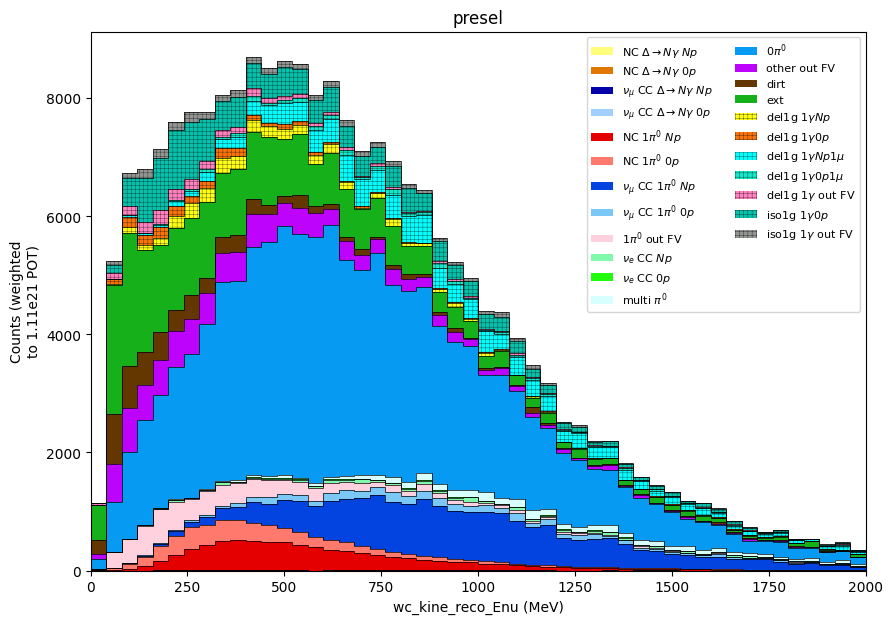

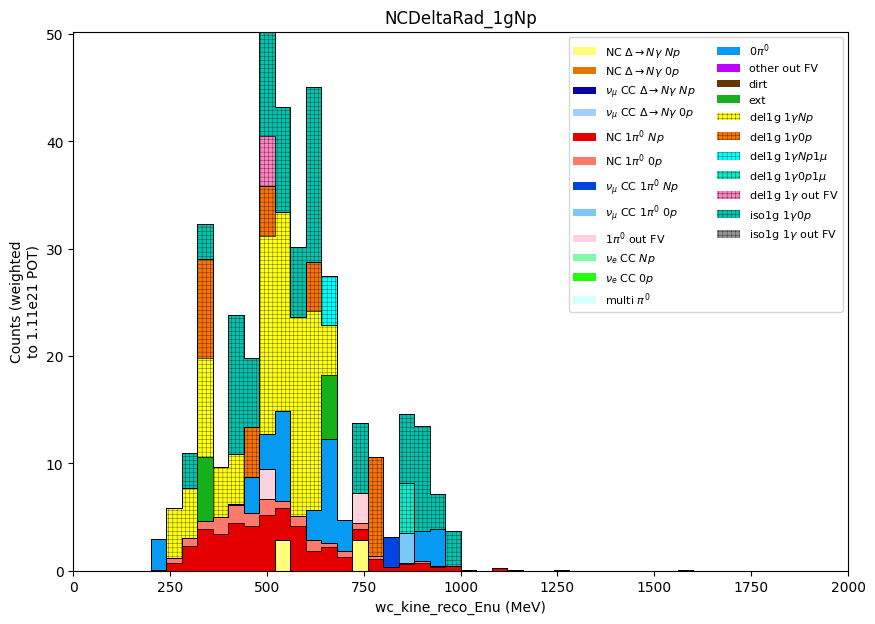

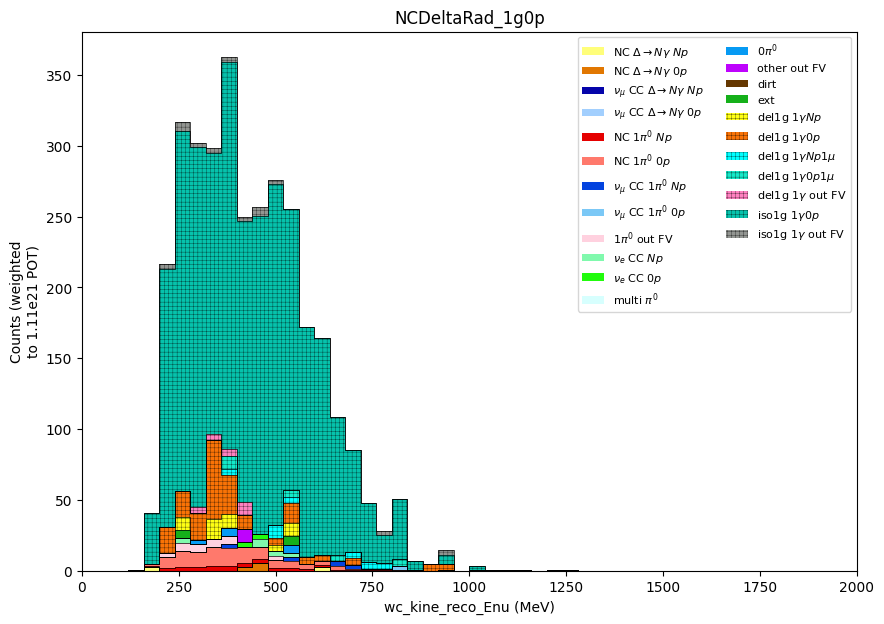

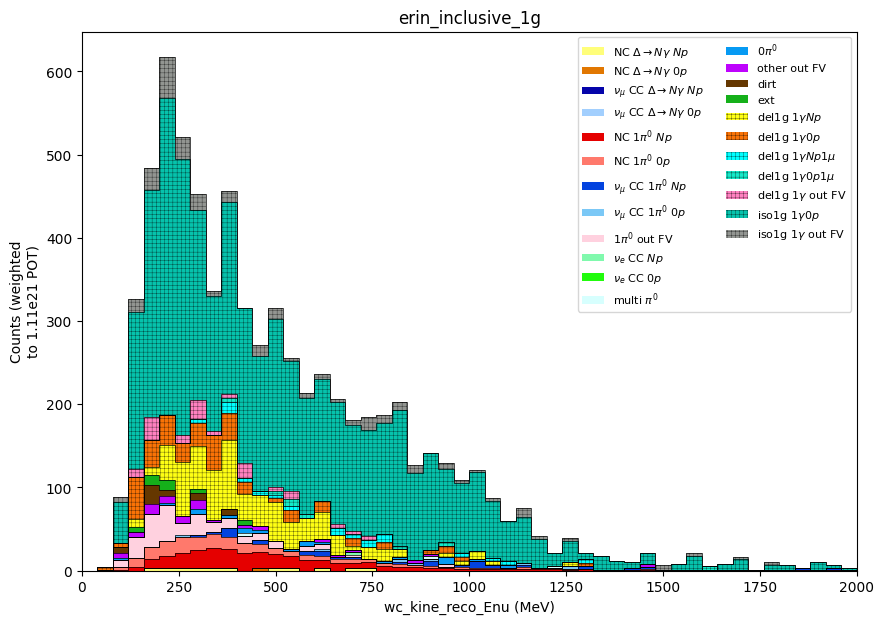

In [6]:
# plotting NC Delta Rad 1gNp vs 1g0p and Erin Inclusive 1g selections

mpl.rcParams['hatch.linewidth'] = 0.2

for sel in ["presel", "NCDeltaRad_1gNp", "NCDeltaRad_1g0p", "erin_inclusive_1g"]:
    for breakdown_type in ["del1g_detailed"]:
        if breakdown_type == "topological":
            breakdown_labels = topological_category_labels
            breakdown_colors = topological_category_colors
            breakdown_hatches = topological_category_hatches
            breakdown_labels_latex = topological_category_labels_latex
            breakdown_queries = []
            for label in breakdown_labels:
                breakdown_queries.append(f"topological_signal_category == '{label}'")
        elif breakdown_type == "filetype":
            breakdown_labels = filetype_category_labels
            breakdown_colors = filetype_category_colors
            breakdown_hatches = filetype_category_hatches
            breakdown_labels_latex = filetype_category_labels_latex
            breakdown_queries = []
            for label in breakdown_labels:
                breakdown_queries.append(f"filetype_signal_category == '{label}'")
        elif breakdown_type == "del1g_detailed":
            breakdown_labels = del1g_detailed_category_labels
            breakdown_colors = del1g_detailed_category_colors
            breakdown_hatches = del1g_detailed_category_hatches
            breakdown_labels_latex = del1g_detailed_category_labels_latex
            breakdown_queries = []
            for label in breakdown_labels:
                breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
        else:
            raise ValueError("Invalid breakdown type")
        
        plt.figure(figsize=(10, 7))
        ax = plt.gca()

        bins = np.linspace(0, 2000, 51)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)

        if sel == "presel":
            sel_df = presel_merged_df
        elif sel == "NCDeltaRad_1gNp":
            sel_df = presel_merged_df.query("wc_kine_reco_Enu > 0 and wc_nc_delta_score > 2.61 and wc_reco_num_protons>0")
        elif sel == "NCDeltaRad_1g0p":
            sel_df = presel_merged_df.query("wc_kine_reco_Enu > 0 and wc_nc_delta_score > 2.61 and wc_reco_num_protons==0")
        elif sel == "erin_inclusive_1g":
            sel_df = presel_merged_df.query("erin_inclusive_1g_sel == 1")
        else:
            raise ValueError("Invalid selection")
        
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_kine_reco_Enu"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        plt.xlabel(r"wc_kine_reco_Enu (MeV)")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=8)
        plt.title(sel)
        plt.show()


In [7]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()
reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)
presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax

# assign a string to reco_category column according to the index and the list reco_sig_categories

presel_merged_df["reco_category"] = [reco_sig_categories[i] for i in reco_categories_argmax]


# Preselection Efficiencies

In [8]:
breakdown_queries = []
for label in del1g_detailed_category_labels:
    breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")

total_num_truth_by_category = [np.sum(merged_df.query(query)["wc_net_weight"]) for query in breakdown_queries]
total_num_generic_truth_by_category = [np.sum(generic_merged_df.query(query)["wc_net_weight"]) for query in breakdown_queries]
total_num_presel_truth_by_category = [np.sum(presel_merged_df.query(query)["wc_net_weight"]) for query in breakdown_queries]

print("WC Generic Selection Topological Efficiencies:")
for i in range(len(del1g_detailed_category_labels)):
    print(f"{del1g_detailed_category_labels[i]}: {total_num_generic_truth_by_category[i]} / {total_num_truth_by_category[i]} = {total_num_generic_truth_by_category[i] / total_num_truth_by_category[i]:.3f}")

print("\nPreselection Topological Efficiencies:")
for i in range(len(del1g_detailed_category_labels)):
    print(f"{del1g_detailed_category_labels[i]}: {total_num_presel_truth_by_category[i]} / {total_num_truth_by_category[i]} = {total_num_presel_truth_by_category[i] / total_num_truth_by_category[i]:.3f}")


WC Generic Selection Topological Efficiencies:
NCDeltaRad_1gNp: 90.19344024675347 / 149.38288540868538 = 0.604
NCDeltaRad_1g0p: 42.27817511566568 / 98.64907526988662 = 0.429
numuCCDeltaRad_1gNp: 87.37489523904246 / 126.8345253469971 = 0.689
numuCCDeltaRad_1g0p: 16.911270046266274 / 28.185450077110456 = 0.600
NC1pi0_Np: 9008.103201831305 / 13734.42431553108 = 0.656
NC1pi0_0p: 5291.393350775476 / 9456.901796841597 = 0.560
numuCC1pi0_Np: 24261.750707759333 / 31258.507993386098 = 0.776
numuCC1pi0_0p: 3935.4643740902475 / 5361.648311482221 = 0.734
1pi0_outFV: 9805.501262744334 / 130282.37666038907 = 0.075
nueCC_Np: 1614.61445124091 / 2005.1047045675477 = 0.805
nueCC_0p: 344.2255476909636 / 472.1616713037505 = 0.729
multi_pi0: 3955.7136773153725 / 5002.692370441759 = 0.791
0pi0: 410289.16174228035 / 629754.230253922 = 0.652
other_outFV: 34351.35597290994 / 1022096.5829556852 = 0.034
dirt: 21616.136112131917 / 799483.5354381755 = 0.027
ext: 73720.63511679092 / 6438125.965353303 = 0.011
del1g_

# Argmax Efficiencies

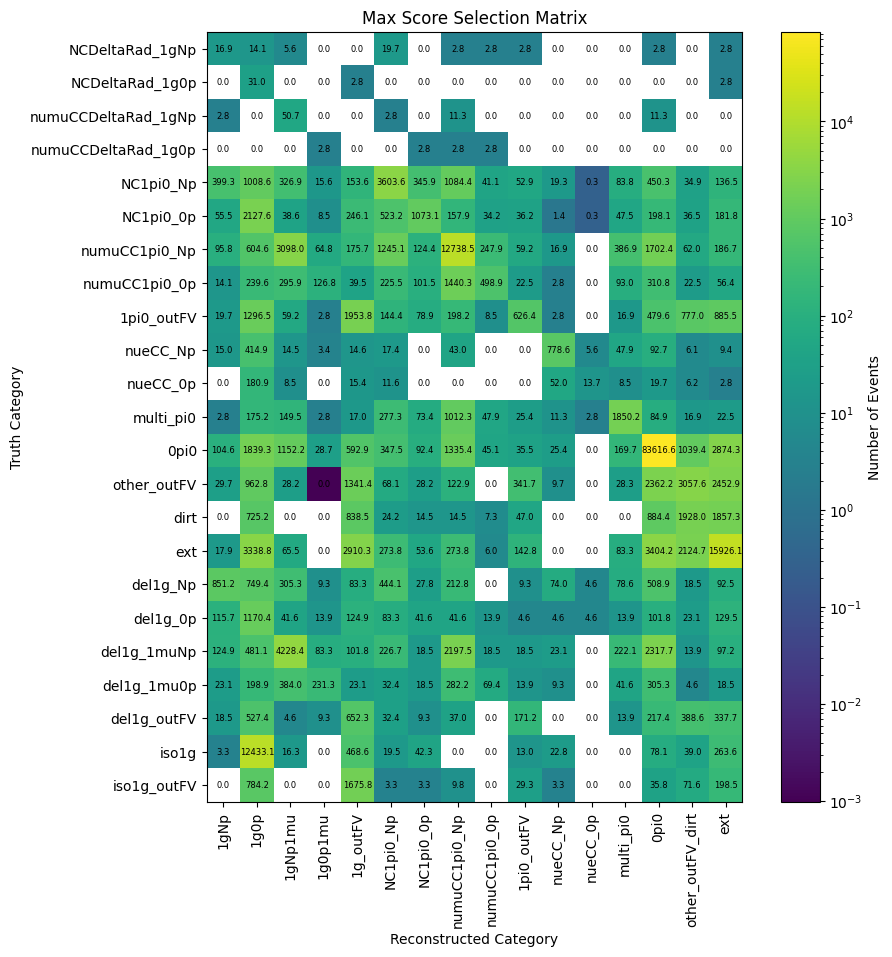

In [9]:
argmax_sel_matrix = np.zeros((len(del1g_detailed_category_labels), len(reco_sig_categories)))
for i in range(len(del1g_detailed_category_labels)):
    for j in range(len(reco_sig_categories)):
        argmax_sel_matrix[i, j] = presel_merged_df.query(f"del1g_detailed_signal_category == '{del1g_detailed_category_labels[i]}' and reco_category_argmax_index == {j}")["wc_net_weight"].sum()

plt.figure(figsize=(10, 10))
plt.imshow(argmax_sel_matrix, norm=mpl.colors.LogNorm())
plt.colorbar(label="Number of Events")
for i in range(len(del1g_detailed_category_labels)):
    for j in range(len(reco_sig_categories)):
        plt.text(j, i, f'{argmax_sel_matrix[i,j]:.1f}', ha='center', va='center', fontsize=6)
plt.xticks(range(len(reco_sig_categories)), reco_sig_categories, rotation=90)
plt.yticks(range(len(del1g_detailed_category_labels)), del1g_detailed_category_labels)
plt.xlabel("Reconstructed Category")
plt.ylabel("Truth Category")
plt.title("Max Score Selection Matrix")
plt.show()


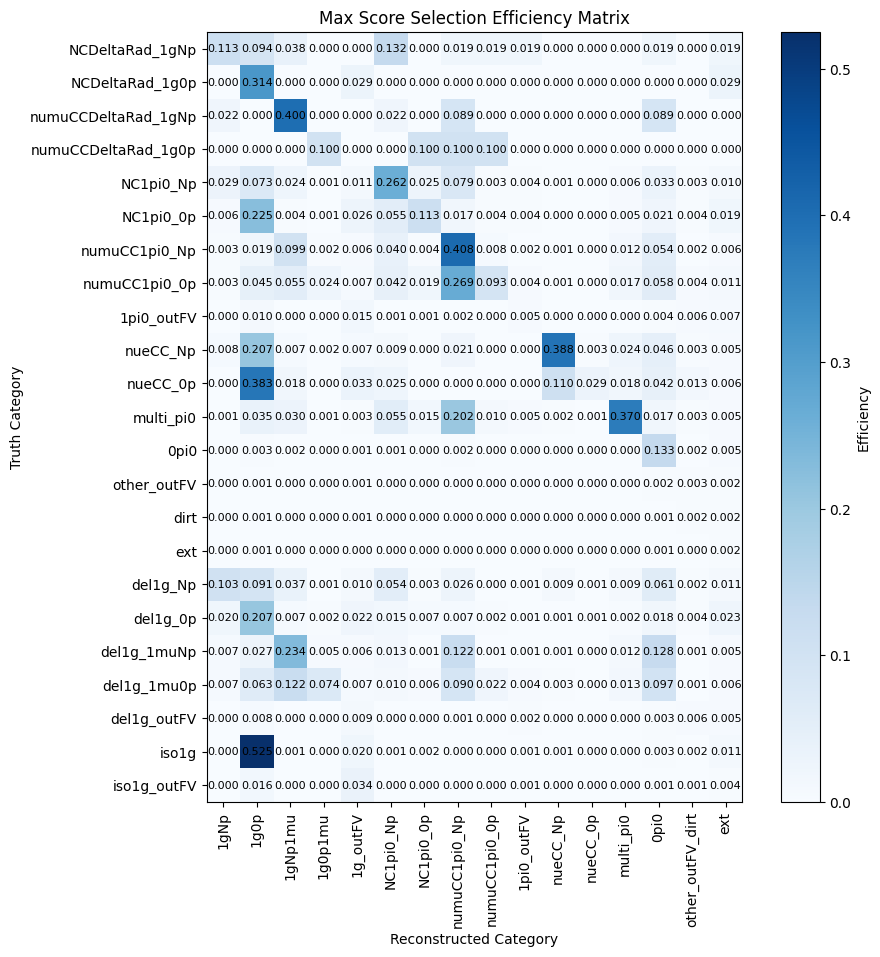

In [10]:
argmax_eff_matrix = (argmax_sel_matrix.T / total_num_truth_by_category).T

plt.figure(figsize=(10, 10))
plt.imshow(argmax_eff_matrix, cmap="Blues")
plt.colorbar(label="Efficiency")
for i in range(len(del1g_detailed_category_labels)):
    for j in range(len(reco_sig_categories)):
        plt.text(j, i, f'{argmax_eff_matrix[i,j]:.3f}', ha='center', va='center', fontsize=8)
plt.xticks(range(len(reco_sig_categories)), reco_sig_categories, rotation=90)
plt.yticks(range(len(del1g_detailed_category_labels)), del1g_detailed_category_labels)
plt.xlabel("Reconstructed Category")
plt.ylabel("Truth Category")
plt.title("Max Score Selection Efficiency Matrix")
plt.show()

# 1g Efficiencies By Cut Value

In [11]:
presel_merged_df["prob_1g"] = (presel_merged_df["prob_1gNp"] 
                             + presel_merged_df["prob_1g0p"]
                             + presel_merged_df["prob_1gNp1mu"]
                             + presel_merged_df["prob_1g0p1mu"])
presel_merged_df["prob_1g0mu"] = (presel_merged_df["prob_1gNp"] + presel_merged_df["prob_1g0p"])
presel_merged_df["prob_1g1mu"] = (presel_merged_df["prob_1gNp1mu"] + presel_merged_df["prob_1g0p1mu"])

presel_merged_df["prob_NC1pi0"] = (presel_merged_df["prob_NC1pi0_Np"] + presel_merged_df["prob_NC1pi0_0p"])
presel_merged_df["prob_numuCC1pi0"] = (presel_merged_df["prob_numuCC1pi0_Np"] + presel_merged_df["prob_numuCC1pi0_0p"])
presel_merged_df["prob_nueCC"] = (presel_merged_df["prob_nueCC_Np"] + presel_merged_df["prob_nueCC_0p"])

presel_merged_df.loc[merged_df["wc_kine_reco_Enu"] < 0, "wc_nc_delta_score_generic"] = -999
presel_merged_df.loc[merged_df["wc_nc_delta_score"].isna(), "wc_nc_delta_score_generic"] = -999


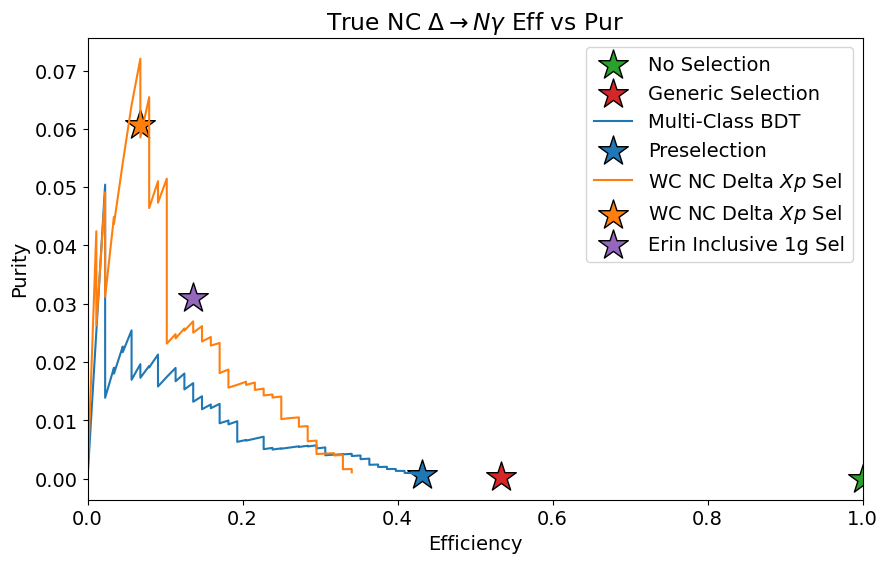

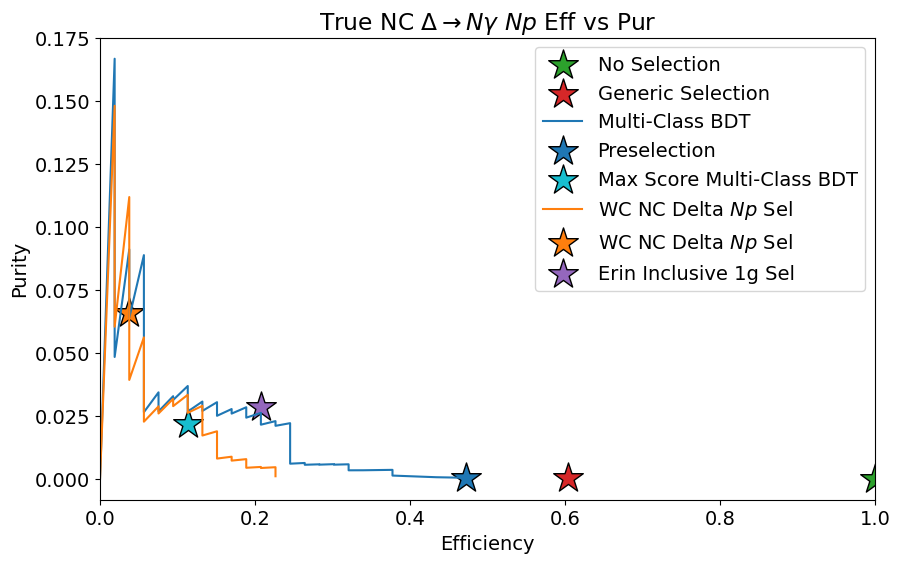

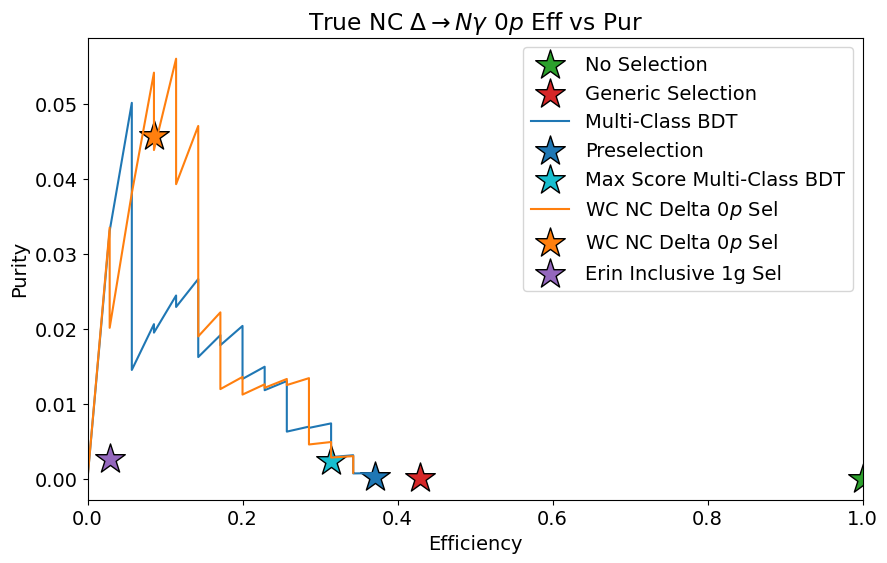

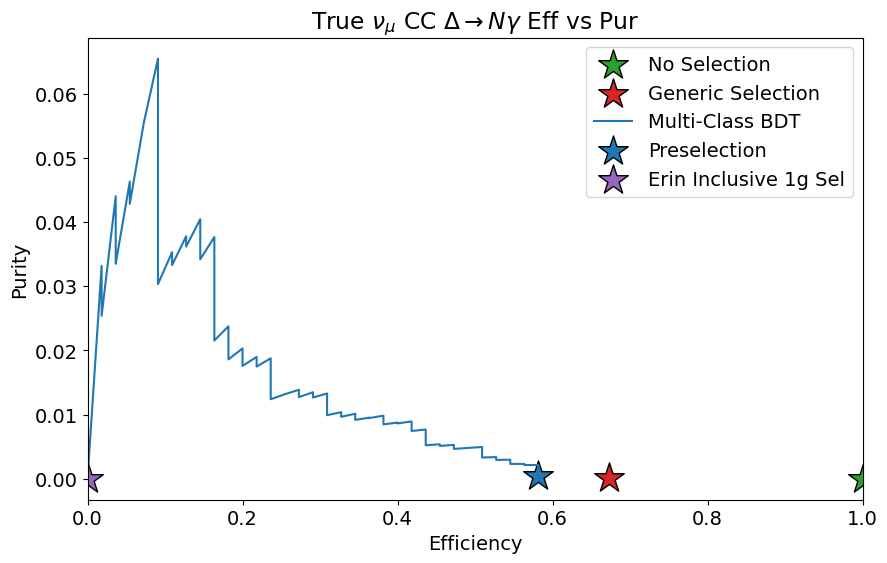

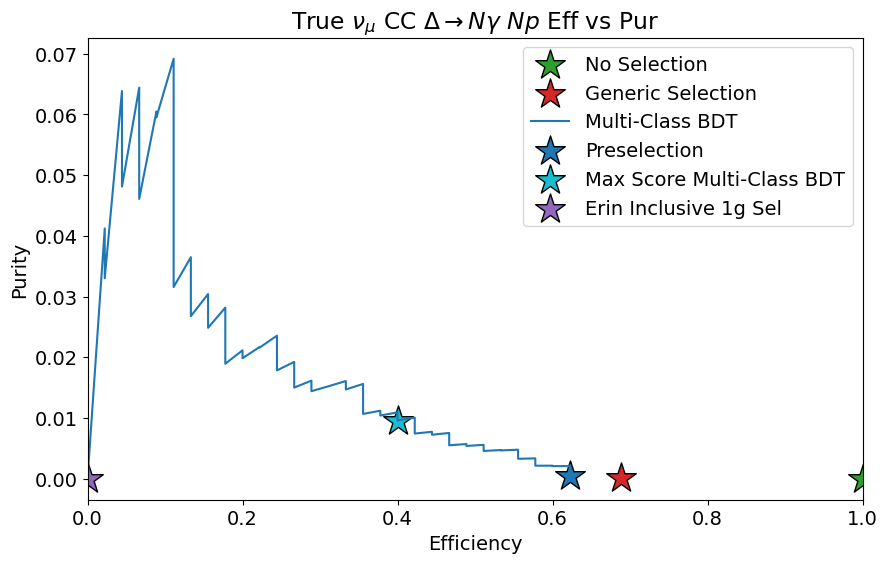

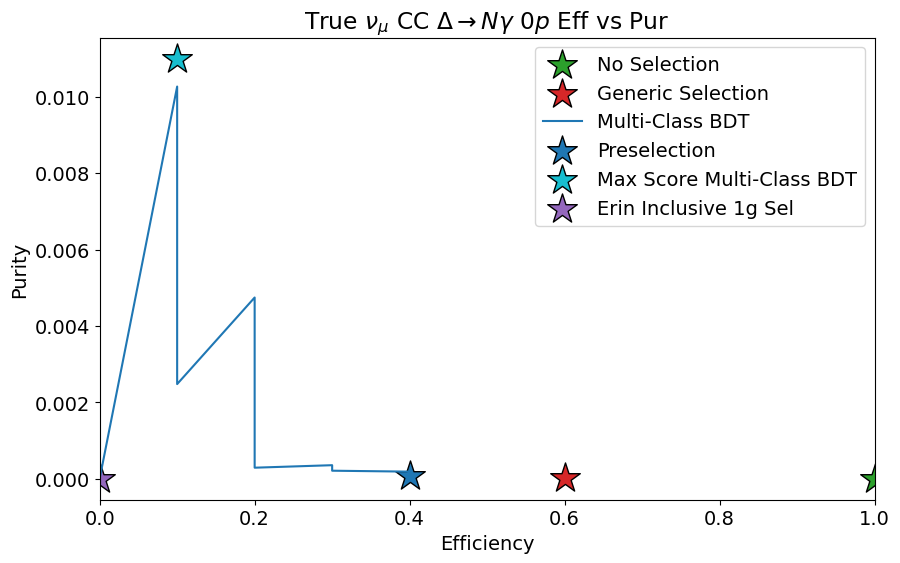

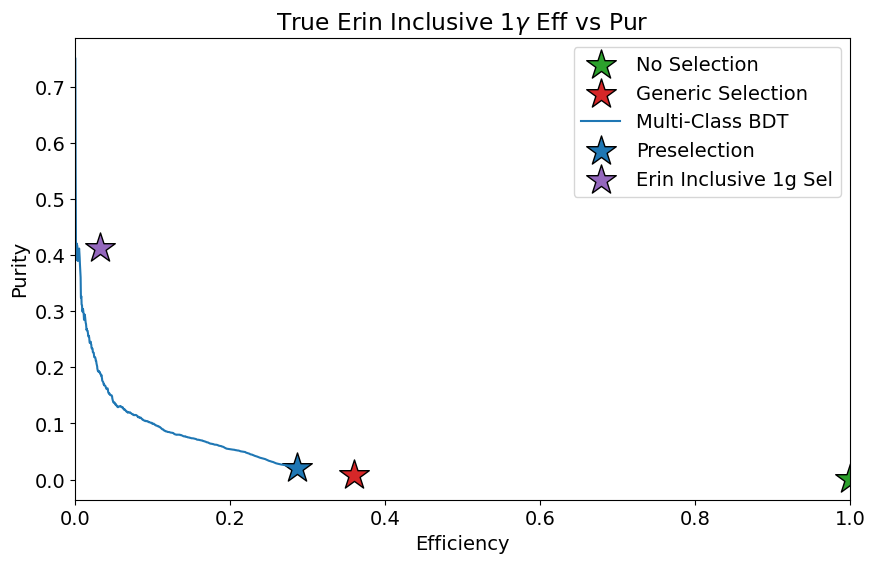

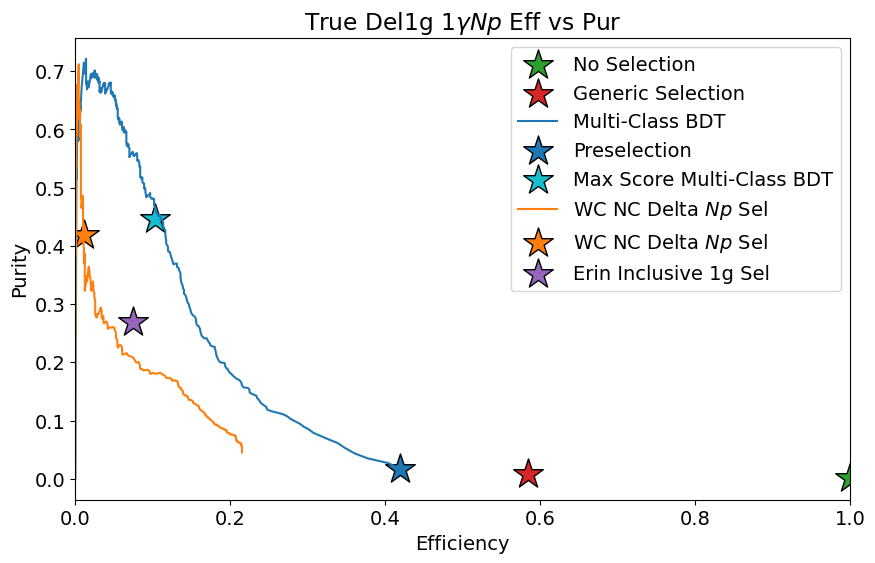

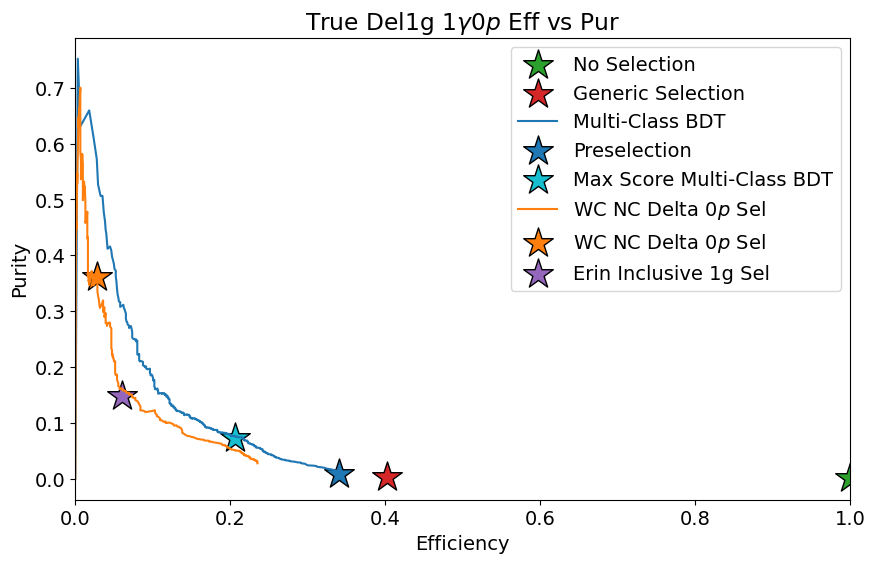

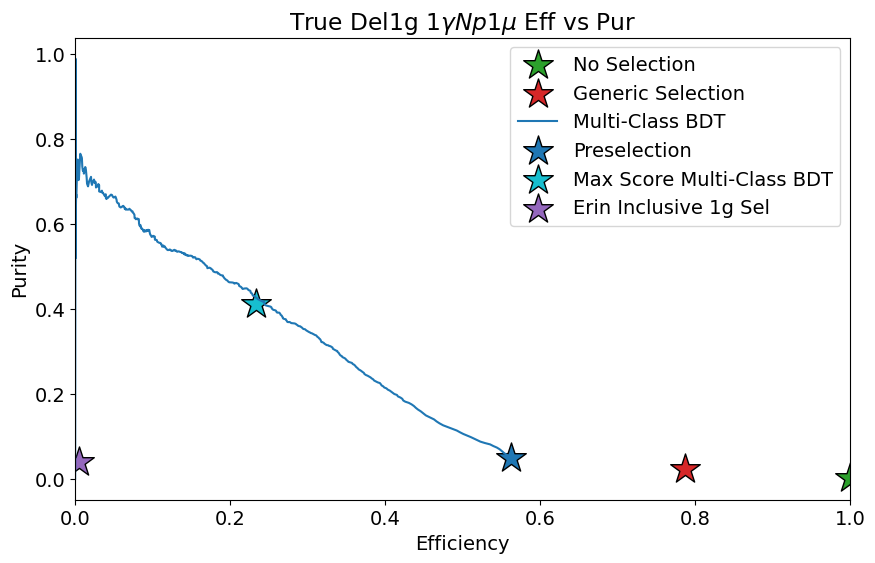

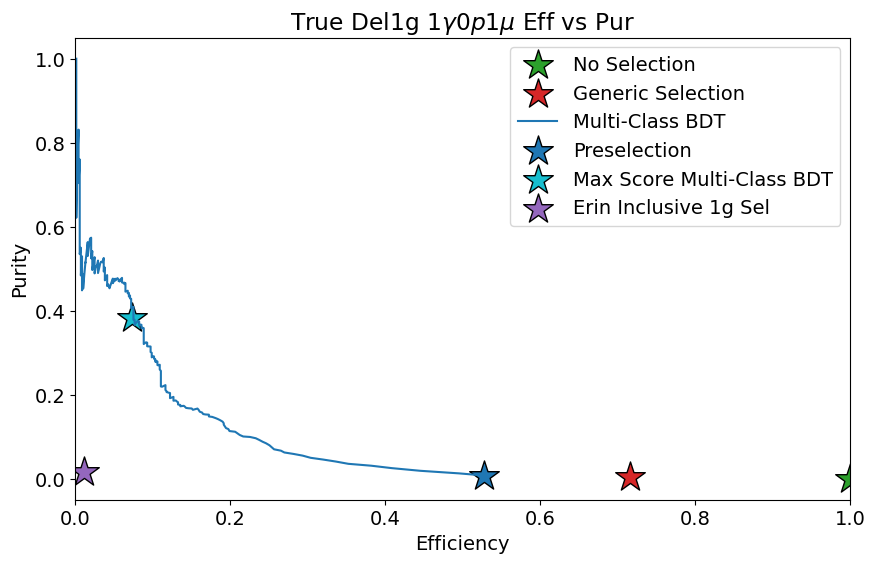

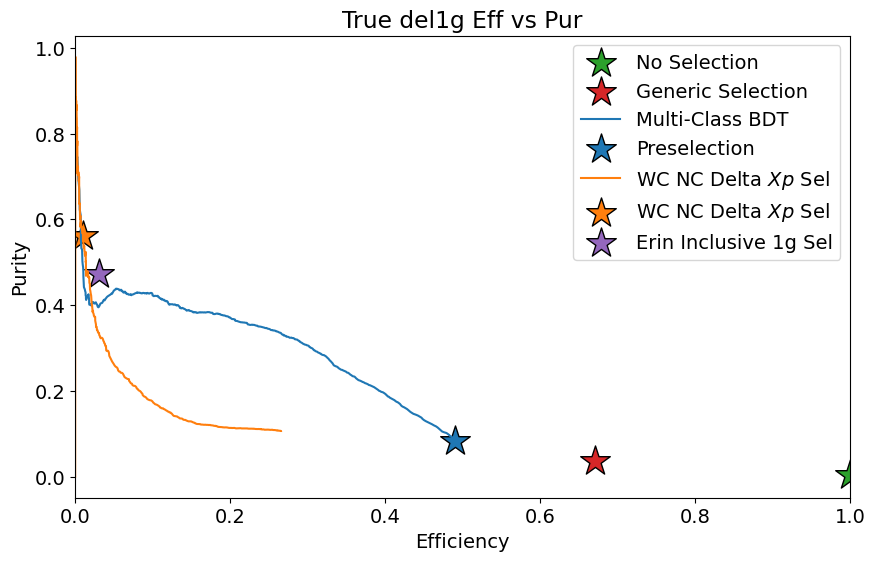

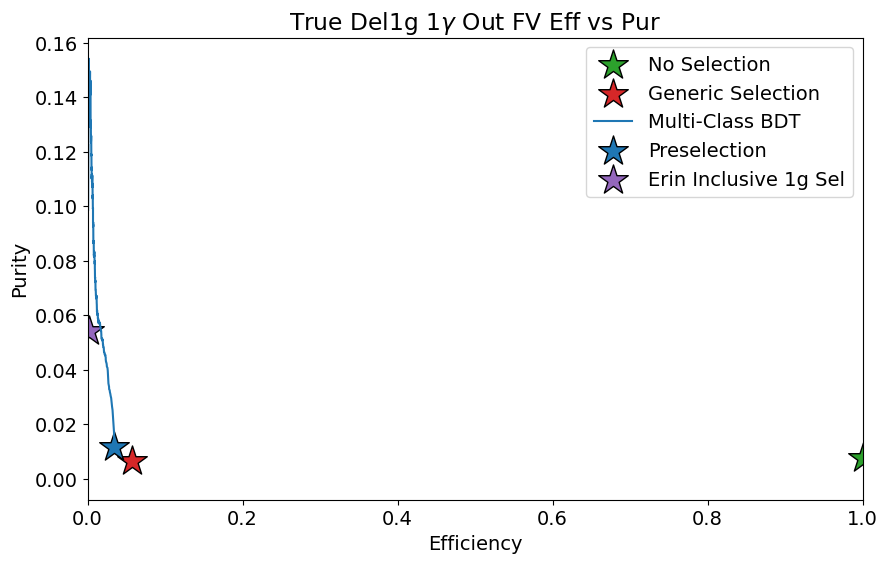

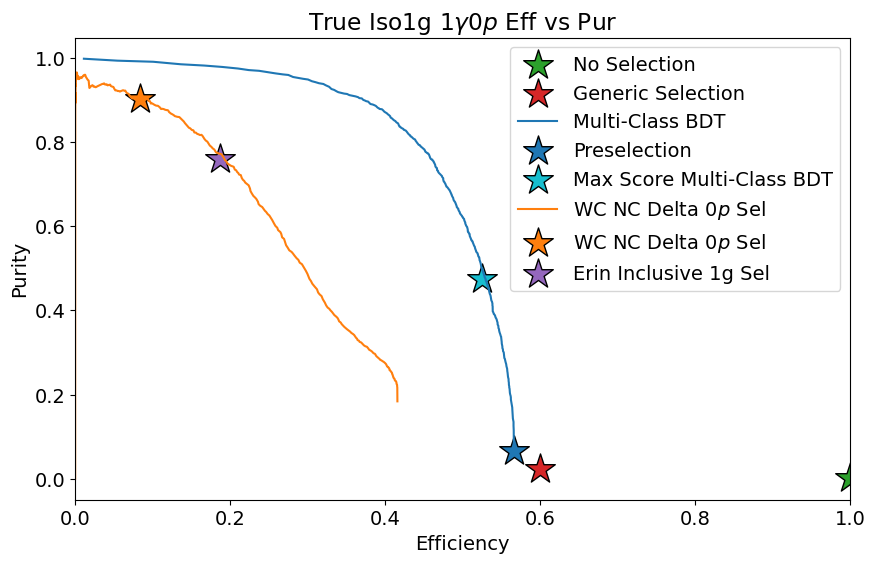

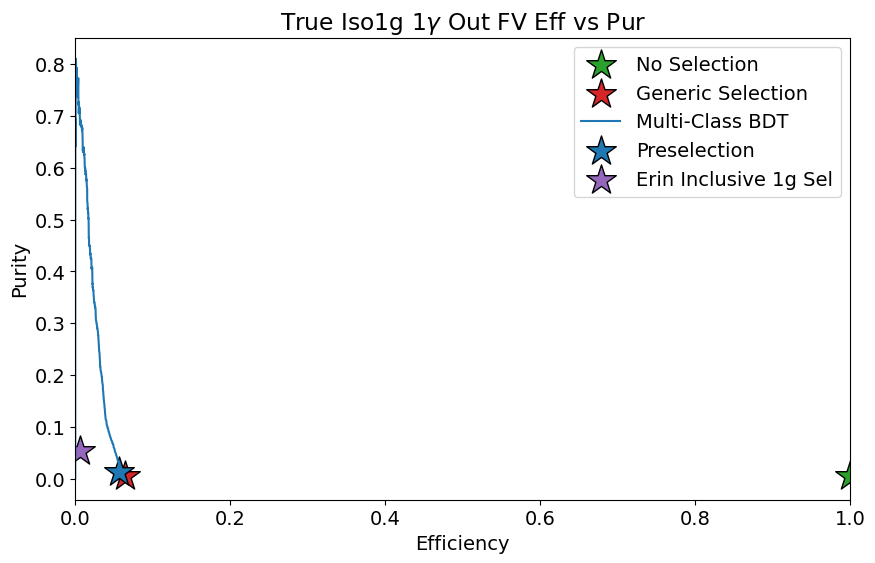

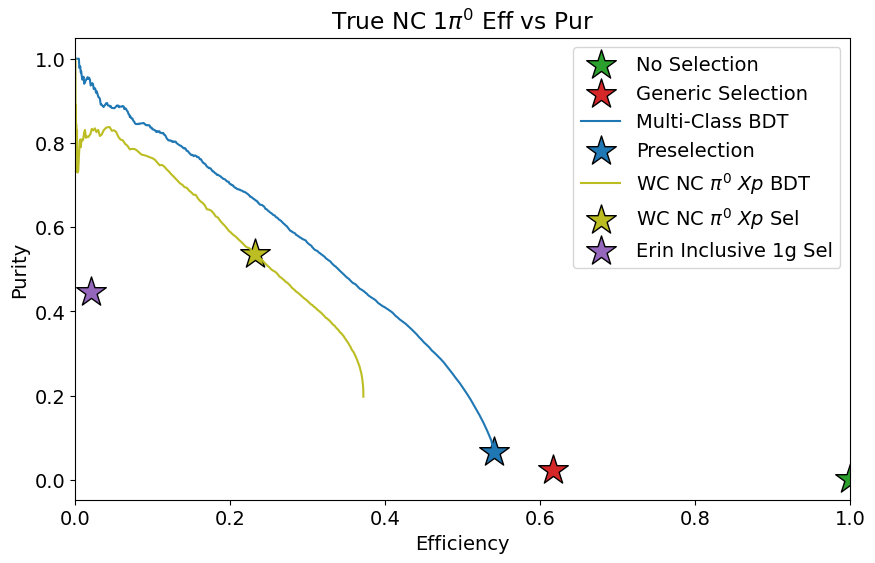

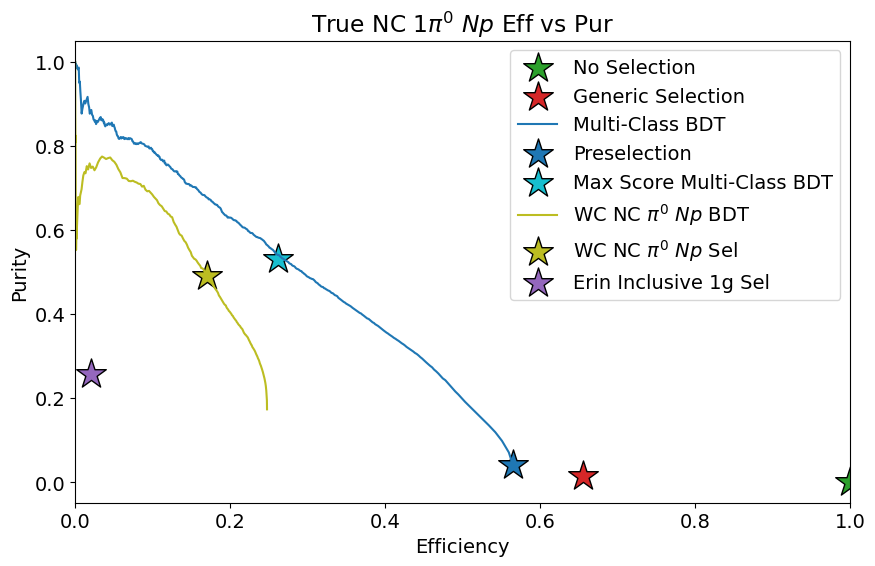

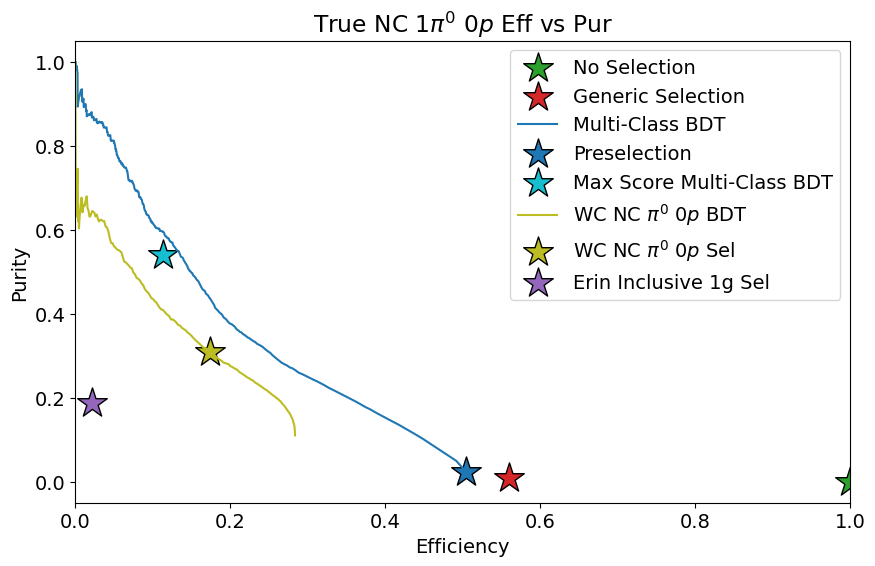

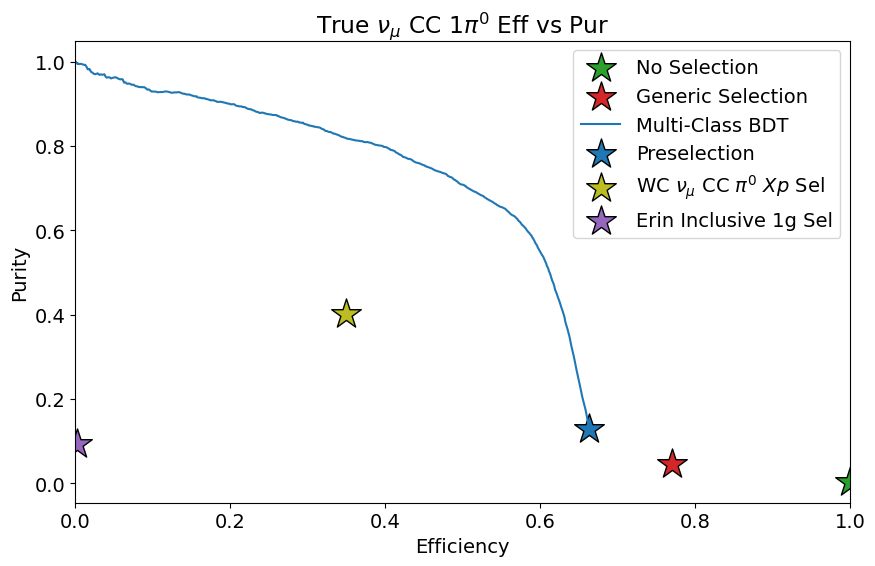

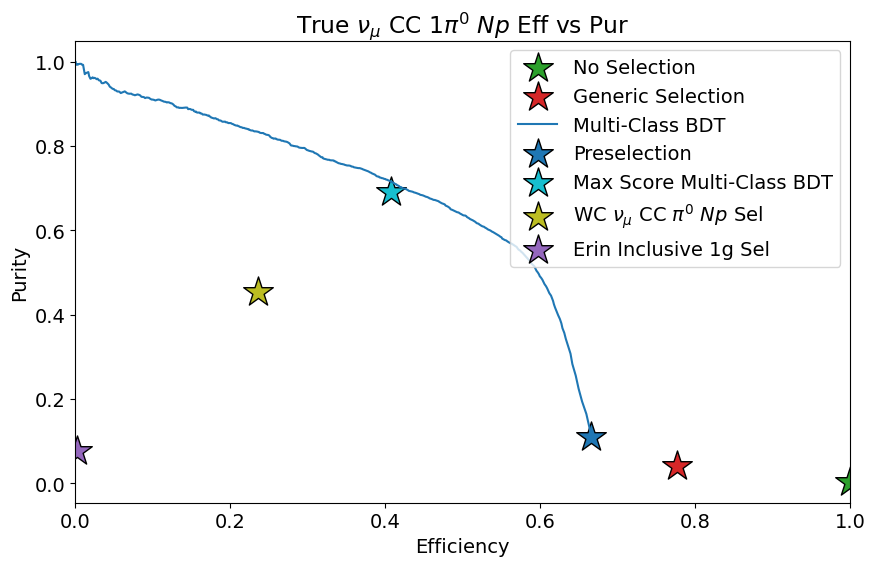

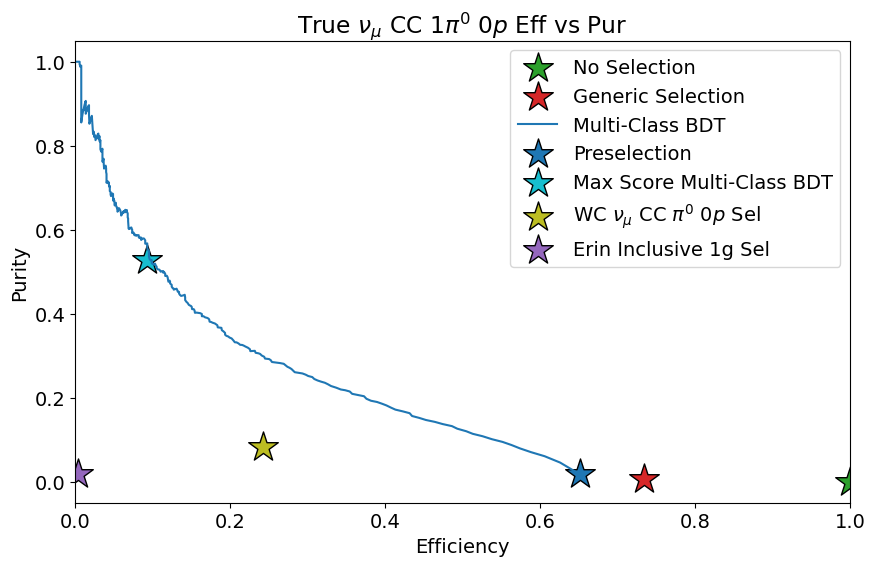

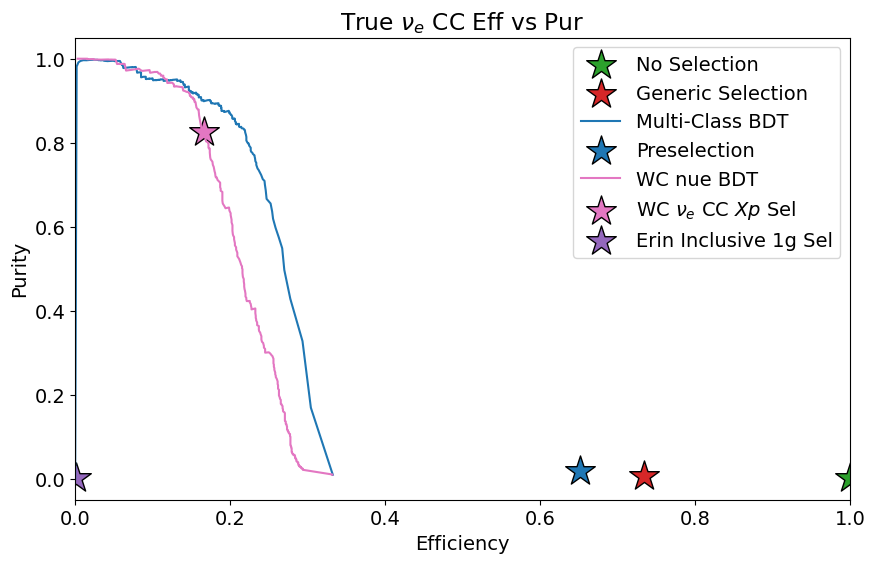

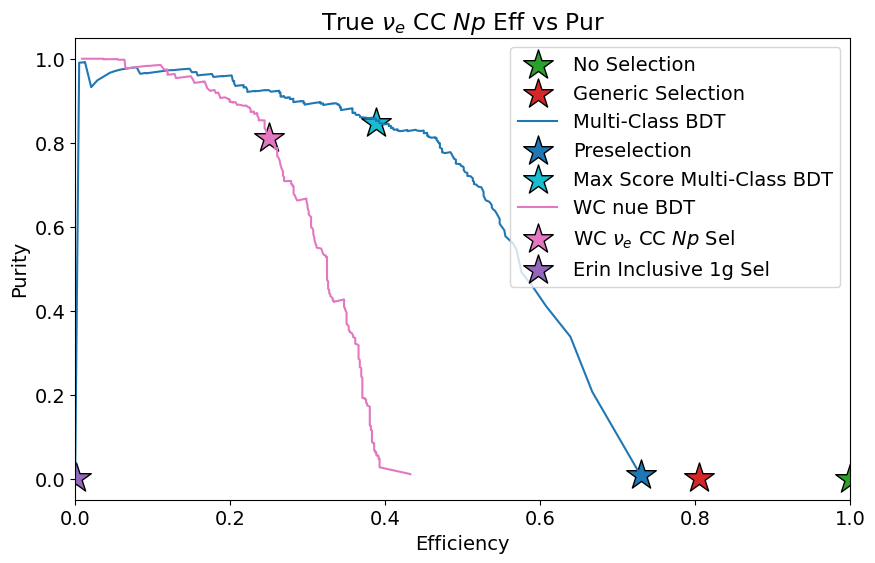

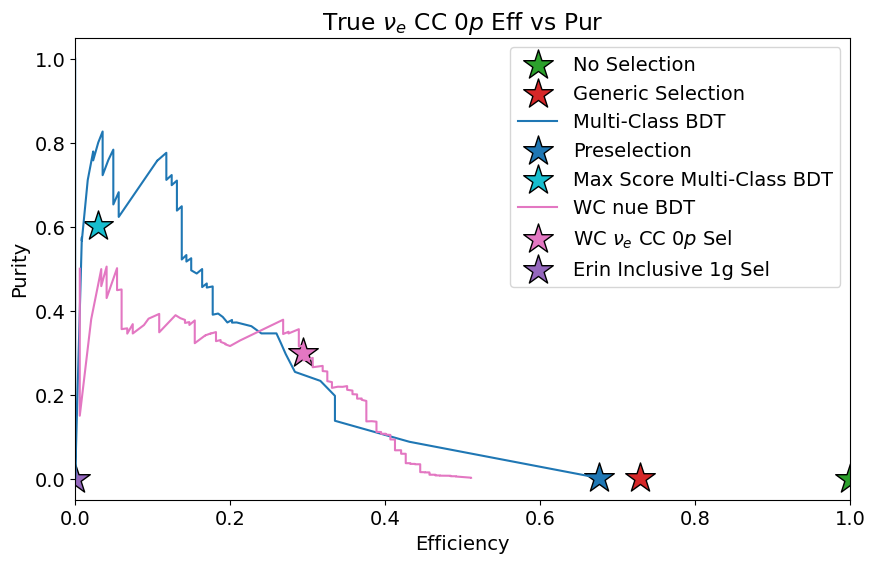

In [12]:
plt.rcParams.update({'font.size': 14})

eff_eval_cats = [
    "NCDeltaRad", "NCDeltaRad_1gNp", "NCDeltaRad_1g0p", 
    "numuCCDeltaRad", "numuCCDeltaRad_1gNp", "numuCCDeltaRad_1g0p", 
    "erin_inclusive_1g",
    "del1g_Np", "del1g_0p", "del1g_1muNp", "del1g_1mu0p", "del1g", "del1g_outFV", 
    "iso1g", "iso1g_outFV",
    "NC1pi0", "NC1pi0_Np", "NC1pi0_0p",
    "numuCC1pi0", "numuCC1pi0_Np", "numuCC1pi0_0p",
    "nueCC", "nueCC_Np", "nueCC_0p",
]

for eff_eval_cat in eff_eval_cats:

    eff_eval_cat_latex = eff_eval_cat
    if eff_eval_cat == "NCDeltaRad":
        eff_eval_cat_latex = r"NC $\Delta\rightarrow N \gamma$"
    elif eff_eval_cat == "NCDeltaRad_1gNp":
        eff_eval_cat_latex = r"NC $\Delta\rightarrow N \gamma$ $Np$"
    elif eff_eval_cat == "NCDeltaRad_1g0p":
        eff_eval_cat_latex = r"NC $\Delta\rightarrow N \gamma$ $0p$"
    elif eff_eval_cat == "numuCCDeltaRad":
        eff_eval_cat_latex = r"$\nu_\mu$ CC $\Delta\rightarrow N \gamma$"
    elif eff_eval_cat == "numuCCDeltaRad_1gNp":
        eff_eval_cat_latex = r"$\nu_\mu$ CC $\Delta\rightarrow N \gamma$ $Np$"
    elif eff_eval_cat == "numuCCDeltaRad_1g0p":
        eff_eval_cat_latex = r"$\nu_\mu$ CC $\Delta\rightarrow N \gamma$ $0p$"
    elif eff_eval_cat == "erin_inclusive_1g":
        eff_eval_cat_latex = r"Erin Inclusive $1\gamma$"
    elif eff_eval_cat == "del1g_Np":
        eff_eval_cat_latex = r"Del1g $1\gamma Np$"
    elif eff_eval_cat == "del1g_0p":
        eff_eval_cat_latex = r"Del1g $1\gamma0p$"
    elif eff_eval_cat == "del1g_1muNp":
        eff_eval_cat_latex = r"Del1g $1\gamma Np1\mu$"
    elif eff_eval_cat == "del1g_1mu0p":
        eff_eval_cat_latex = r"Del1g $1\gamma 0p1\mu$"
    elif eff_eval_cat == "del1g_outFV":
        eff_eval_cat_latex = r"Del1g $1\gamma$ Out FV"
    elif eff_eval_cat == "iso1g":
        eff_eval_cat_latex = r"Iso1g $1\gamma 0p$"
    elif eff_eval_cat == "iso1g_outFV":
        eff_eval_cat_latex = r"Iso1g $1\gamma$ Out FV"
    elif eff_eval_cat == "NC1pi0":
        eff_eval_cat_latex = r"NC 1$\pi^0$"
    elif eff_eval_cat == "NC1pi0_Np":
        eff_eval_cat_latex = r"NC 1$\pi^0$ $Np$"
    elif eff_eval_cat == "NC1pi0_0p":
        eff_eval_cat_latex = r"NC 1$\pi^0$ $0p$"
    elif eff_eval_cat == "numuCC1pi0":
        eff_eval_cat_latex = r"$\nu_\mu$ CC 1$\pi^0$"
    elif eff_eval_cat == "numuCC1pi0_Np":
        eff_eval_cat_latex = r"$\nu_\mu$ CC 1$\pi^0$ $Np$"
    elif eff_eval_cat == "numuCC1pi0_0p":
        eff_eval_cat_latex = r"$\nu_\mu$ CC 1$\pi^0$ $0p$"
    elif eff_eval_cat == "nueCC":
        eff_eval_cat_latex = r"$\nu_e$ CC"
    elif eff_eval_cat == "nueCC_Np":
        eff_eval_cat_latex = r"$\nu_e$ CC $Np$"
    elif eff_eval_cat == "nueCC_0p":
        eff_eval_cat_latex = r"$\nu_e$ CC $0p$"
        
    if "del1g" in eff_eval_cat:
        rel_filetypes_merged_df = merged_df.query("not iso1g_overlay")
        rel_filetypes_presel_merged_df = presel_merged_df.query("not iso1g_overlay")
    elif "iso1g" in eff_eval_cat:
        rel_filetypes_merged_df = merged_df.query("not del1g_overlay")
        rel_filetypes_presel_merged_df = presel_merged_df.query("not del1g_overlay")
    else:
        rel_filetypes_merged_df = merged_df.query("not del1g_overlay and not iso1g_overlay")
        rel_filetypes_presel_merged_df = presel_merged_df.query("not del1g_overlay and not iso1g_overlay")

    if eff_eval_cat == "NCDeltaRad":
        NCDeltaRad_query = "del1g_detailed_signal_category == 'NCDeltaRad_1gNp' or del1g_detailed_signal_category == 'NCDeltaRad_1g0p'"
        all_sig_df = rel_filetypes_merged_df.query(NCDeltaRad_query)
        all_bkg_df = rel_filetypes_merged_df.query(f"not {NCDeltaRad_query}")
        sig_df = rel_filetypes_presel_merged_df.query(NCDeltaRad_query)
        bkg_df = rel_filetypes_presel_merged_df.query(f"not {NCDeltaRad_query}")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])
    elif eff_eval_cat == "numuCCDeltaRad":
        numuCCDeltaRad_query = "del1g_detailed_signal_category == 'numuCCDeltaRad_1gNp' or del1g_detailed_signal_category == 'numuCCDeltaRad_1g0p'"
        all_sig_df = rel_filetypes_merged_df.query(numuCCDeltaRad_query)
        all_bkg_df = rel_filetypes_merged_df.query(f"not {numuCCDeltaRad_query}")
        sig_df = rel_filetypes_presel_merged_df.query(numuCCDeltaRad_query)
        bkg_df = rel_filetypes_presel_merged_df.query(f"not {numuCCDeltaRad_query}")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])

    elif eff_eval_cat == "erin_inclusive_1g":
        all_sig_df = rel_filetypes_merged_df.query(f"erin_inclusive_1g_true_sig == 1")
        all_bkg_df = rel_filetypes_merged_df.query(f"erin_inclusive_1g_true_sig == 0")
        sig_df = rel_filetypes_presel_merged_df.query(f"erin_inclusive_1g_true_sig == 1")
        bkg_df = rel_filetypes_presel_merged_df.query(f"erin_inclusive_1g_true_sig == 0")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])

    elif eff_eval_cat == "del1g":
        del1g_query = f"""del1g_detailed_signal_category == 'del1g_Np'
                        or del1g_detailed_signal_category == 'del1g_0p'
                        or del1g_detailed_signal_category == 'del1g_1muNp'
                        or del1g_detailed_signal_category == 'del1g_1mu0p'""".strip().replace("\n", "")
        all_sig_df = rel_filetypes_merged_df.query(f"{del1g_query}")
        all_bkg_df = rel_filetypes_merged_df.query(f"not ({del1g_query})")
        sig_df = rel_filetypes_presel_merged_df.query(f"{del1g_query}")
        bkg_df = rel_filetypes_presel_merged_df.query(f"not ({del1g_query})")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])
    
    elif eff_eval_cat == "NC1pi0":
        NC1pi0_query = "del1g_detailed_signal_category == 'NC1pi0_Np' or del1g_detailed_signal_category == 'NC1pi0_0p'"
        all_sig_df = rel_filetypes_merged_df.query(NC1pi0_query)
        all_bkg_df = rel_filetypes_merged_df.query(f"not ({NC1pi0_query})")
        sig_df = rel_filetypes_presel_merged_df.query(NC1pi0_query)
        bkg_df = rel_filetypes_presel_merged_df.query(f"not ({NC1pi0_query})")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])

    elif eff_eval_cat == "numuCC1pi0":
        numuCC1pi0_query = "del1g_detailed_signal_category == 'numuCC1pi0_Np' or del1g_detailed_signal_category == 'numuCC1pi0_0p'"
        all_sig_df = rel_filetypes_merged_df.query(numuCC1pi0_query)
        all_bkg_df = rel_filetypes_merged_df.query(f"not ({numuCC1pi0_query})")
        sig_df = rel_filetypes_presel_merged_df.query(numuCC1pi0_query)
        bkg_df = rel_filetypes_presel_merged_df.query(f"not ({numuCC1pi0_query})")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])

    elif eff_eval_cat == "nueCC":
        nueCC_query = "del1g_detailed_signal_category == 'nueCC_Np' or del1g_detailed_signal_category == 'nueCC_0p'"
        rel_filetypes_merged_df = merged_df.query(nueCC_query)
        rel_filetypes_merged_df = merged_df.query(f"not ({nueCC_query})")
        sig_df = rel_filetypes_presel_merged_df.query(nueCC_query)
        bkg_df = rel_filetypes_presel_merged_df.query(f"not ({nueCC_query})")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])

    else:
        all_sig_df = rel_filetypes_merged_df.query(f"del1g_detailed_signal_category == '{eff_eval_cat}'")
        all_bkg_df = rel_filetypes_merged_df.query(f"del1g_detailed_signal_category != '{eff_eval_cat}'")
        sig_df = rel_filetypes_presel_merged_df.query(f"del1g_detailed_signal_category == '{eff_eval_cat}'")
        bkg_df = rel_filetypes_presel_merged_df.query(f"del1g_detailed_signal_category != '{eff_eval_cat}'")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])

    if total_sig == 0:
        print(f"{rel_filetypes_merged_df['del1g_detailed_signal_category'].unique()=}")
        raise ValueError(f"No signal events found for {eff_eval_cat}")

    multi_class_bdt_score_name = f"prob_{eff_eval_cat}"
    
    if eff_eval_cat == "NCDeltaRad":
        multi_class_bdt_score_name = "prob_1g0mu"
    elif eff_eval_cat == "NCDeltaRad_1gNp":
        multi_class_bdt_score_name = "prob_1gNp"
    elif eff_eval_cat == "NCDeltaRad_1g0p":
        multi_class_bdt_score_name = "prob_1g0p"

    elif eff_eval_cat == "numuCCDeltaRad":
        multi_class_bdt_score_name = "prob_1g1mu"
    elif eff_eval_cat == "numuCCDeltaRad_1gNp":
        multi_class_bdt_score_name = "prob_1gNp1mu"
    elif eff_eval_cat == "numuCCDeltaRad_1g0p":
        multi_class_bdt_score_name = "prob_1g0p1mu"

    elif eff_eval_cat == "erin_inclusive_1g":
        multi_class_bdt_score_name = "prob_1g"

    elif eff_eval_cat == "del1g":
        multi_class_bdt_score_name = "prob_1g"
    elif eff_eval_cat == "del1g_Np":
        multi_class_bdt_score_name = "prob_1gNp"
    elif eff_eval_cat == "del1g_0p":
        multi_class_bdt_score_name = "prob_1g0p"
    elif eff_eval_cat == "del1g_1muNp":
        multi_class_bdt_score_name = "prob_1gNp1mu"
    elif eff_eval_cat == "del1g_1mu0p":
        multi_class_bdt_score_name = "prob_1g0p1mu"
    elif eff_eval_cat == "del1g_outFV":
        multi_class_bdt_score_name = "prob_1g_outFV"

    elif eff_eval_cat == "iso1g":
        multi_class_bdt_score_name = "prob_1g0p"
    elif eff_eval_cat == "iso1g_outFV":
        multi_class_bdt_score_name = "prob_1g_outFV"
    
    else:
        multi_class_bdt_score_name = f"prob_{eff_eval_cat}"

    sig_bdt_scores = sig_df[multi_class_bdt_score_name].to_numpy()
    bkg_bdt_scores = bkg_df[multi_class_bdt_score_name].to_numpy()
    sig_weights = sig_df["wc_net_weight"].to_numpy()
    bkg_weights = bkg_df["wc_net_weight"].to_numpy()

    num_points = 500
    cutoffs = np.linspace(0, 1, num_points)
    all_effs = []
    all_purs = []
    for cutoff in cutoffs:
        sig_sel_weights = sig_weights[sig_bdt_scores > cutoff]
        sig_sel = np.sum(sig_sel_weights)
        bkg_sel_weights = bkg_weights[bkg_bdt_scores > cutoff]
        bkg_sel = np.sum(bkg_sel_weights)
        eff = sig_sel / total_sig if total_sig > 0 else np.nan
        pur = sig_sel / (sig_sel + bkg_sel) if sig_sel + bkg_sel > 0 else np.nan
        all_effs.append(eff)
        all_purs.append(pur)

    max_score_eff = None
    max_score_pur = None
    # evaluate the max-score selection efficiency and purity (default multi-class plotting cut value)
    if eff_eval_cat in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "1g_outFV", "NC1pi0_Np", "NC1pi0_0p", "numuCC1pi0_Np", "numuCC1pi0_0p", "nueCC_Np", "nueCC_0p", 
                                                    "del1g_Np", "del1g_0p", "del1g_1muNp", "del1g_1mu0p", "iso1g",
                                                    "NCDeltaRad_1gNp", "NCDeltaRad_1g0p", "numuCCDeltaRad_1gNp", "numuCCDeltaRad_1g0p"]:

        curr_reco_cat = eff_eval_cat
        if eff_eval_cat == "del1g_Np" or eff_eval_cat == "NCDeltaRad_1gNp":
            curr_reco_cat = "1gNp"
        elif eff_eval_cat == "del1g_0p" or eff_eval_cat == "iso1g" or eff_eval_cat == "NCDeltaRad_1g0p":
            curr_reco_cat = "1g0p"
        elif eff_eval_cat == "del1g_1muNp" or eff_eval_cat == "numuCCDeltaRad_1gNp":
            curr_reco_cat = "1gNp1mu"
        elif eff_eval_cat == "del1g_1mu0p" or eff_eval_cat == "numuCCDeltaRad_1g0p":
            curr_reco_cat = "1g0p1mu"
        sig_reco_categories = sig_df["reco_category"].to_numpy()
        max_score_sig_sel_weights = sig_weights[sig_reco_categories == curr_reco_cat]
        max_score_sig_sel = np.sum(max_score_sig_sel_weights)
        bkg_reco_categories = bkg_df["reco_category"].to_numpy()    
        max_score_bkg_sel_weights = bkg_weights[bkg_reco_categories == curr_reco_cat]
        max_score_bkg_sel = np.sum(max_score_bkg_sel_weights)
        max_score_eff = max_score_sig_sel / total_sig if total_sig > 0 else np.nan
        max_score_pur = max_score_sig_sel / (max_score_sig_sel + max_score_bkg_sel) if max_score_sig_sel + max_score_bkg_sel > 0 else np.nan            

    if eff_eval_cat in ["NCDeltaRad", "NCDeltaRad_1gNp", "NCDeltaRad_1g0p", "del1g", "del1g_Np", "del1g_0p", "iso1g"]:
        # efficiency and purity curve for the WC NC Delta BDT, Np, 0p, and Xp (later, we only plot the proton state that makes sense for the signal category)
        sig_nc_delta_bdt_scores = sig_df["wc_nc_delta_score"].to_numpy()
        bkg_nc_delta_bdt_scores = bkg_df["wc_nc_delta_score"].to_numpy()
        sig_wc_reco_num_protons = sig_df["wc_reco_num_protons"].to_numpy()
        bkg_wc_reco_num_protons = bkg_df["wc_reco_num_protons"].to_numpy()
        sig_wc_match_isFCs = sig_df["wc_match_isFC"].to_numpy()
        bkg_wc_match_isFCs = bkg_df["wc_match_isFC"].to_numpy()
        all_nc_delta_bdt_scores = np.concatenate([sig_nc_delta_bdt_scores, bkg_nc_delta_bdt_scores])
        good_nc_delta_bdt_scores = all_nc_delta_bdt_scores[all_nc_delta_bdt_scores == all_nc_delta_bdt_scores]
        min_delta_score, max_delta_score = np.min(good_nc_delta_bdt_scores), np.max(good_nc_delta_bdt_scores)
        cutoffs = np.linspace(min_delta_score, max_delta_score, num_points)
        all_effs_nc_delta_Xp = []
        all_purs_nc_delta_Xp = []
        all_effs_nc_delta_Np = []
        all_purs_nc_delta_Np = []
        all_effs_nc_delta_0p = []
        all_purs_nc_delta_0p = []
        for cutoff in cutoffs:
            sig_sel_weights = sig_weights[np.logical_and(sig_nc_delta_bdt_scores > cutoff, sig_wc_match_isFCs == 1)]
            sig_sel = np.sum(sig_sel_weights)
            bkg_sel_weights = bkg_weights[np.logical_and(bkg_nc_delta_bdt_scores > cutoff, bkg_wc_match_isFCs == 1)]
            bkg_sel = np.sum(bkg_sel_weights)
            eff = sig_sel / total_sig if total_sig > 0 else np.nan
            pur = sig_sel / (sig_sel + bkg_sel) if sig_sel + bkg_sel > 0 else np.nan
            all_effs_nc_delta_Xp.append(eff)
            all_purs_nc_delta_Xp.append(pur)
            Np_sig_sel_weights = sig_weights[np.logical_and(np.logical_and(sig_nc_delta_bdt_scores > cutoff, sig_wc_match_isFCs == 1), sig_wc_reco_num_protons > 0)]
            Np_sig_sel = np.sum(Np_sig_sel_weights)
            Np_bkg_sel_weights = bkg_weights[np.logical_and(np.logical_and(bkg_nc_delta_bdt_scores > cutoff, bkg_wc_match_isFCs == 1), bkg_wc_reco_num_protons > 0)]
            Np_bkg_sel = np.sum(Np_bkg_sel_weights)
            Np_eff = Np_sig_sel / total_sig if total_sig > 0 else np.nan
            Np_pur = Np_sig_sel / (Np_sig_sel + Np_bkg_sel) if Np_sig_sel + Np_bkg_sel > 0 else np.nan
            all_effs_nc_delta_Np.append(Np_eff)
            all_purs_nc_delta_Np.append(Np_pur)
            zero_p_sig_sel_weights = sig_weights[np.logical_and(np.logical_and(sig_nc_delta_bdt_scores > cutoff, sig_wc_match_isFCs == 1), sig_wc_reco_num_protons == 0)]
            zero_p_sig_sel = np.sum(zero_p_sig_sel_weights)
            zero_p_bkg_sel_weights = bkg_weights[np.logical_and(np.logical_and(bkg_nc_delta_bdt_scores > cutoff, bkg_wc_match_isFCs == 1), bkg_wc_reco_num_protons == 0)]
            zero_p_bkg_sel = np.sum(zero_p_bkg_sel_weights)
            zero_p_eff = zero_p_sig_sel / total_sig if total_sig > 0 else np.nan
            zero_p_pur = zero_p_sig_sel / (zero_p_sig_sel + zero_p_bkg_sel) if zero_p_sig_sel + zero_p_bkg_sel > 0 else np.nan
            all_effs_nc_delta_0p.append(zero_p_eff)
            all_purs_nc_delta_0p.append(zero_p_pur)
        nc_delta_261_Xp_sig_sel_weights = sig_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1")["wc_net_weight"].to_numpy()
        nc_delta_261_Xp_sig_sel = np.sum(nc_delta_261_Xp_sig_sel_weights)
        nc_delta_261_Xp_bkg_sel_weights = bkg_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1")["wc_net_weight"].to_numpy()
        nc_delta_261_Xp_bkg_sel = np.sum(nc_delta_261_Xp_bkg_sel_weights)
        nc_delta_261_Xp_eff = nc_delta_261_Xp_sig_sel / total_sig if total_sig > 0 else np.nan
        nc_delta_261_Xp_pur = nc_delta_261_Xp_sig_sel / (nc_delta_261_Xp_sig_sel + nc_delta_261_Xp_bkg_sel) if nc_delta_261_Xp_sig_sel + nc_delta_261_Xp_bkg_sel > 0 else np.nan
        nc_delta_261_Np_sig_sel_weights = sig_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1 and wc_reco_num_protons>0")["wc_net_weight"].to_numpy()
        nc_delta_261_Np_sig_sel = np.sum(nc_delta_261_Np_sig_sel_weights)
        nc_delta_261_Np_bkg_sel_weights = bkg_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1 and wc_reco_num_protons>0")["wc_net_weight"].to_numpy()
        nc_delta_261_Np_bkg_sel = np.sum(nc_delta_261_Np_bkg_sel_weights)
        nc_delta_261_Np_eff = nc_delta_261_Np_sig_sel / total_sig if total_sig > 0 else np.nan
        nc_delta_261_Np_pur = nc_delta_261_Np_sig_sel / (nc_delta_261_Np_sig_sel + nc_delta_261_Np_bkg_sel) if nc_delta_261_Np_sig_sel + nc_delta_261_Np_bkg_sel > 0 else np.nan
        nc_delta_261_0p_sig_sel_weights = sig_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1 and wc_reco_num_protons==0")["wc_net_weight"].to_numpy()
        nc_delta_261_0p_sig_sel = np.sum(nc_delta_261_0p_sig_sel_weights)
        nc_delta_261_0p_bkg_sel_weights = bkg_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1 and wc_reco_num_protons==0")["wc_net_weight"].to_numpy()
        nc_delta_261_0p_bkg_sel = np.sum(nc_delta_261_0p_bkg_sel_weights)
        nc_delta_261_0p_eff = nc_delta_261_0p_sig_sel / total_sig if total_sig > 0 else np.nan
        nc_delta_261_0p_pur = nc_delta_261_0p_sig_sel / (nc_delta_261_0p_sig_sel + nc_delta_261_0p_bkg_sel) if nc_delta_261_0p_sig_sel + nc_delta_261_0p_bkg_sel > 0 else np.nan

    # efficiency and purity curve for the WC nueCC BDT, Np, 0p, and Xp (later, we only plot the proton state that makes sense for the signal category)
    if "nueCC" in eff_eval_cat:
        sig_nue_bdt_scores = sig_df["wc_nue_score"].to_numpy()
        bkg_nue_bdt_scores = bkg_df["wc_nue_score"].to_numpy()
        sig_wc_reco_num_protons = sig_df["wc_reco_num_protons"].to_numpy()
        bkg_wc_reco_num_protons = bkg_df["wc_reco_num_protons"].to_numpy()
        all_nue_bdt_scores = np.concatenate([sig_nue_bdt_scores, bkg_nue_bdt_scores])
        good_nue_bdt_scores = np.nan_to_num(all_nue_bdt_scores, nan=0, posinf=0, neginf=0)
        min_nue_score, max_nue_score = np.min(good_nue_bdt_scores), np.max(good_nue_bdt_scores)
        cutoffs = np.linspace(min_nue_score, max_nue_score, num_points)
        all_effs_nue_Xp = []
        all_purs_nue_Xp = []
        all_effs_nue_Np = []
        all_purs_nue_Np = []
        all_effs_nue_0p = []
        all_purs_nue_0p = []
        for cutoff in cutoffs:
            Xp_sig_sel_weights = sig_weights[sig_nue_bdt_scores > cutoff]
            Xp_sig_sel = np.sum(Xp_sig_sel_weights)
            Xp_bkg_sel_weights = bkg_weights[bkg_nue_bdt_scores > cutoff]
            Xp_bkg_sel = np.sum(Xp_bkg_sel_weights)
            Xp_eff = Xp_sig_sel / total_sig if total_sig > 0 else np.nan
            Xp_pur = Xp_sig_sel / (Xp_sig_sel + Xp_bkg_sel) if Xp_sig_sel + Xp_bkg_sel > 0 else np.nan
            all_effs_nue_Xp.append(Xp_eff)
            all_purs_nue_Xp.append(Xp_pur)
            Np_sig_sel_weights = sig_weights[np.logical_and(sig_nue_bdt_scores > cutoff, sig_wc_reco_num_protons > 0)]
            Np_sig_sel = np.sum(Np_sig_sel_weights)
            Np_bkg_sel_weights = bkg_weights[np.logical_and(bkg_nue_bdt_scores > cutoff, bkg_wc_reco_num_protons > 0)]
            Np_bkg_sel = np.sum(Np_bkg_sel_weights)
            Np_eff = Np_sig_sel / total_sig if total_sig > 0 else np.nan
            Np_pur = Np_sig_sel / (Np_sig_sel + Np_bkg_sel) if Np_sig_sel + Np_bkg_sel > 0 else np.nan
            all_effs_nue_Np.append(Np_eff)
            all_purs_nue_Np.append(Np_pur)
            zero_p_sig_sel_weights = sig_weights[np.logical_and(sig_nue_bdt_scores > cutoff, sig_wc_reco_num_protons == 0)]
            zero_p_sig_sel = np.sum(zero_p_sig_sel_weights)
            zero_p_bkg_sel_weights = bkg_weights[np.logical_and(bkg_nue_bdt_scores > cutoff, bkg_wc_reco_num_protons == 0)]
            zero_p_bkg_sel = np.sum(zero_p_bkg_sel_weights)
            zero_p_eff = zero_p_sig_sel / total_sig if total_sig > 0 else np.nan
            zero_p_pur = zero_p_sig_sel / (zero_p_sig_sel + zero_p_bkg_sel) if zero_p_sig_sel + zero_p_bkg_sel > 0 else np.nan
            all_effs_nue_0p.append(zero_p_eff)
            all_purs_nue_0p.append(zero_p_pur)
        nue_7_Xp_sig_sel_weights = sig_df.query("wc_nue_score > 7")["wc_net_weight"].to_numpy()
        nue_7_Xp_sig_sel = np.sum(nue_7_Xp_sig_sel_weights)
        nue_7_Xp_bkg_sel_weights = bkg_df.query("wc_nue_score > 7")["wc_net_weight"].to_numpy()
        nue_7_Xp_bkg_sel = np.sum(nue_7_Xp_bkg_sel_weights)
        nue_7_Xp_eff = nue_7_Xp_sig_sel / total_sig if total_sig > 0 else np.nan
        nue_7_Xp_pur = nue_7_Xp_sig_sel / (nue_7_Xp_sig_sel + nue_7_Xp_bkg_sel) if nue_7_Xp_sig_sel + nue_7_Xp_bkg_sel > 0 else np.nan
        nue_7_Np_sig_sel_weights = sig_df.query("wc_nue_score > 7 and wc_reco_num_protons>0")["wc_net_weight"].to_numpy()
        nue_7_Np_sig_sel = np.sum(nue_7_Np_sig_sel_weights)
        nue_7_Np_bkg_sel_weights = bkg_df.query("wc_nue_score > 7 and wc_reco_num_protons>0")["wc_net_weight"].to_numpy()
        nue_7_Np_bkg_sel = np.sum(nue_7_Np_bkg_sel_weights)
        nue_7_Np_eff = nue_7_Np_sig_sel / total_sig if total_sig > 0 else np.nan
        nue_7_Np_pur = nue_7_Np_sig_sel / (nue_7_Np_sig_sel + nue_7_Np_bkg_sel) if nue_7_Np_sig_sel + nue_7_Np_bkg_sel > 0 else np.nan
        nue_7_0p_sig_sel_weights = sig_df.query("wc_nue_score > 7 and wc_reco_num_protons==0")["wc_net_weight"].to_numpy()
        nue_7_0p_sig_sel = np.sum(nue_7_0p_sig_sel_weights)
        nue_7_0p_bkg_sel_weights = bkg_df.query("wc_nue_score > 7 and wc_reco_num_protons==0")["wc_net_weight"].to_numpy()
        nue_7_0p_bkg_sel = np.sum(nue_7_0p_bkg_sel_weights)
        nue_7_0p_eff = nue_7_0p_sig_sel / total_sig if total_sig > 0 else np.nan
        nue_7_0p_pur = nue_7_0p_sig_sel / (nue_7_0p_sig_sel + nue_7_0p_bkg_sel) if nue_7_0p_sig_sel + nue_7_0p_bkg_sel > 0 else np.nan

    erin_inclusive_1g_sig_sel_weights = sig_df.query("erin_inclusive_1g_sel == 1")["wc_net_weight"].to_numpy()
    erin_inclusive_1g_sig_sel = np.sum(erin_inclusive_1g_sig_sel_weights)
    erin_inclusive_1g_bkg_sel_weights = bkg_df.query("erin_inclusive_1g_sel == 1")["wc_net_weight"].to_numpy()
    erin_inclusive_1g_bkg_sel = np.sum(erin_inclusive_1g_bkg_sel_weights)
    erin_inclusive_1g_eff = erin_inclusive_1g_sig_sel / total_sig if total_sig > 0 else np.nan
    erin_inclusive_1g_pur = erin_inclusive_1g_sig_sel / (erin_inclusive_1g_sig_sel + erin_inclusive_1g_bkg_sel) if erin_inclusive_1g_sig_sel + erin_inclusive_1g_bkg_sel > 0 else np.nan

    # efficiency and purity curve for the WC NC pi0 BDT, Np, 0p, and Xp (later, we only plot the proton state that makes sense for the signal category)
    if "NC1pi0" in eff_eval_cat:
        nc_pi0_presel_sig_df = sig_df.query("wc_kine_reco_Enu > 0 and wc_kine_pio_energy_1 > 0 and wc_kine_pio_energy_2 > 0 and wc_match_isFC==1 and not (wc_reco_showerKE > 0 and wc_nc_delta_score > 2.61)")
        nc_pi0_presel_bkg_df = bkg_df.query("wc_kine_reco_Enu > 0 and wc_kine_pio_energy_1 > 0 and wc_kine_pio_energy_2 > 0 and wc_match_isFC==1 and not (wc_reco_showerKE > 0 and wc_nc_delta_score > 2.61)")
        nc_pi0_presel_sig_weights = nc_pi0_presel_sig_df["wc_net_weight"].to_numpy()
        nc_pi0_presel_bkg_weights = nc_pi0_presel_bkg_df["wc_net_weight"].to_numpy()
        sig_ncpi0_bdt_scores = nc_pi0_presel_sig_df["wc_nc_pio_score"].to_numpy()
        bkg_ncpi0_bdt_scores = nc_pi0_presel_bkg_df["wc_nc_pio_score"].to_numpy()
        sig_wc_reco_num_protons = nc_pi0_presel_sig_df["wc_reco_num_protons"].to_numpy()
        bkg_wc_reco_num_protons = nc_pi0_presel_bkg_df["wc_reco_num_protons"].to_numpy()
        all_ncpi0_bdt_scores = np.concatenate([sig_ncpi0_bdt_scores, bkg_ncpi0_bdt_scores])
        good_ncpi0_bdt_scores = np.nan_to_num(all_ncpi0_bdt_scores, nan=0, posinf=0, neginf=0)
        min_ncpi0_score, max_ncpi0_score = np.min(good_ncpi0_bdt_scores), np.max(good_ncpi0_bdt_scores)
        cutoffs = np.linspace(min_ncpi0_score, max_ncpi0_score, num_points)
        all_effs_ncpi0_Xp = []
        all_purs_ncpi0_Xp = []
        all_effs_ncpi0_Np = []
        all_purs_ncpi0_Np = []
        all_effs_ncpi0_0p = []
        all_purs_ncpi0_0p = []
        for cutoff in cutoffs:
            Xp_sig_sel_weights = nc_pi0_presel_sig_weights[sig_ncpi0_bdt_scores > cutoff]
            Xp_sig_sel = np.sum(Xp_sig_sel_weights)
            Xp_bkg_sel_weights = nc_pi0_presel_bkg_weights[bkg_ncpi0_bdt_scores > cutoff]
            Xp_bkg_sel = np.sum(Xp_bkg_sel_weights)
            Xp_eff = Xp_sig_sel / total_sig if total_sig > 0 else np.nan
            Xp_pur = Xp_sig_sel / (Xp_sig_sel + Xp_bkg_sel) if Xp_sig_sel + Xp_bkg_sel > 0 else np.nan
            all_effs_ncpi0_Xp.append(Xp_eff)
            all_purs_ncpi0_Xp.append(Xp_pur)
            Np_sig_sel_weights = nc_pi0_presel_sig_weights[np.logical_and(sig_ncpi0_bdt_scores > cutoff, sig_wc_reco_num_protons > 0)]
            Np_sig_sel = np.sum(Np_sig_sel_weights)
            Np_bkg_sel_weights = nc_pi0_presel_bkg_weights[np.logical_and(bkg_ncpi0_bdt_scores > cutoff, bkg_wc_reco_num_protons > 0)]
            Np_bkg_sel = np.sum(Np_bkg_sel_weights)
            Np_eff = Np_sig_sel / total_sig if total_sig > 0 else np.nan
            Np_pur = Np_sig_sel / (Np_sig_sel + Np_bkg_sel) if Np_sig_sel + Np_bkg_sel > 0 else np.nan
            all_effs_ncpi0_Np.append(Np_eff)
            all_purs_ncpi0_Np.append(Np_pur)
            zero_p_sig_sel_weights = nc_pi0_presel_sig_weights[np.logical_and(sig_ncpi0_bdt_scores > cutoff, sig_wc_reco_num_protons == 0)]
            zero_p_sig_sel = np.sum(zero_p_sig_sel_weights)
            zero_p_bkg_sel_weights = nc_pi0_presel_bkg_weights[np.logical_and(bkg_ncpi0_bdt_scores > cutoff, bkg_wc_reco_num_protons == 0)]
            zero_p_bkg_sel = np.sum(zero_p_bkg_sel_weights)
            zero_p_eff = zero_p_sig_sel / total_sig if total_sig > 0 else np.nan
            zero_p_pur = zero_p_sig_sel / (zero_p_sig_sel + zero_p_bkg_sel) if zero_p_sig_sel + zero_p_bkg_sel > 0 else np.nan
            all_effs_ncpi0_0p.append(zero_p_eff)
            all_purs_ncpi0_0p.append(zero_p_pur)
        nc_pi0_1816_Xp_sig_sel_weights = nc_pi0_presel_sig_df.query("wc_nc_pio_score > 1.816")["wc_net_weight"].to_numpy()
        nc_pi0_1816_Xp_sig_sel = np.sum(nc_pi0_1816_Xp_sig_sel_weights)
        nc_pi0_1816_Xp_bkg_sel_weights = nc_pi0_presel_bkg_df.query("wc_nc_pio_score > 1.816")["wc_net_weight"].to_numpy()
        nc_pi0_1816_Xp_bkg_sel = np.sum(nc_pi0_1816_Xp_bkg_sel_weights)
        nc_pi0_1816_Xp_eff = nc_pi0_1816_Xp_sig_sel / total_sig if total_sig > 0 else np.nan
        nc_pi0_1816_Xp_pur = nc_pi0_1816_Xp_sig_sel / (nc_pi0_1816_Xp_sig_sel + nc_pi0_1816_Xp_bkg_sel) if nc_pi0_1816_Xp_sig_sel + nc_pi0_1816_Xp_bkg_sel > 0 else np.nan
        nc_pi0_1816_Np_sig_sel_weights = nc_pi0_presel_sig_df.query("wc_nc_pio_score > 1.816 and wc_reco_num_protons > 0")["wc_net_weight"].to_numpy()
        nc_pi0_1816_Np_sig_sel = np.sum(nc_pi0_1816_Np_sig_sel_weights)
        nc_pi0_1816_Np_bkg_sel_weights = nc_pi0_presel_bkg_df.query("wc_nc_pio_score > 1.816 and wc_reco_num_protons > 0")["wc_net_weight"].to_numpy()
        nc_pi0_1816_Np_bkg_sel = np.sum(nc_pi0_1816_Np_bkg_sel_weights)
        nc_pi0_1816_Np_eff = nc_pi0_1816_Np_sig_sel / total_sig if total_sig > 0 else np.nan
        nc_pi0_1816_Np_pur = nc_pi0_1816_Np_sig_sel / (nc_pi0_1816_Np_sig_sel + nc_pi0_1816_Np_bkg_sel) if nc_pi0_1816_Np_sig_sel + nc_pi0_1816_Np_bkg_sel > 0 else np.nan
        nc_pi0_1816_0p_sig_sel_weights = nc_pi0_presel_sig_df.query("wc_nc_pio_score > 1.816 and wc_reco_num_protons == 0")["wc_net_weight"].to_numpy()
        nc_pi0_1816_0p_sig_sel = np.sum(nc_pi0_1816_0p_sig_sel_weights)
        nc_pi0_1816_0p_bkg_sel_weights = nc_pi0_presel_bkg_df.query("wc_nc_pio_score > 1.816 and wc_reco_num_protons == 0")["wc_net_weight"].to_numpy()
        nc_pi0_1816_0p_bkg_sel = np.sum(nc_pi0_1816_0p_bkg_sel_weights)
        nc_pi0_1816_0p_eff = nc_pi0_1816_0p_sig_sel / total_sig if total_sig > 0 else np.nan
        nc_pi0_1816_0p_pur = nc_pi0_1816_0p_sig_sel / (nc_pi0_1816_0p_sig_sel + nc_pi0_1816_0p_bkg_sel) if nc_pi0_1816_0p_sig_sel + nc_pi0_1816_0p_bkg_sel > 0 else np.nan

    # efficiency and purity for the WC cut-based numuCC Pi0 selection
    if "numuCC1pi0" in eff_eval_cat:
        # see https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h#L3719
        wc_cutbased_cc_pi0_sig_sel_df = sig_df.query("""wc_kine_pio_flag==1 and wc_kine_pio_vtx_dis < 9
                                                    and wc_kine_pio_energy_1 > 40 and wc_kine_pio_energy_2 > 25
                                                    and wc_kine_pio_dis_1 < 110 and wc_kine_pio_dis_2 < 120
                                                    and wc_kine_pio_angle > 0 and wc_kine_pio_angle < 174
                                                    and wc_kine_pio_mass > 22 and wc_kine_pio_mass < 300""".strip().replace("\n", ""))
        wc_cutbased_cc_pi0_bkg_sel_df = bkg_df.query("""wc_kine_pio_flag==1 and wc_kine_pio_vtx_dis < 9
                                                    and wc_kine_pio_energy_1 > 40 and wc_kine_pio_energy_2 > 25
                                                    and wc_kine_pio_dis_1 < 110 and wc_kine_pio_dis_2 < 120
                                                    and wc_kine_pio_angle > 0 and wc_kine_pio_angle < 174
                                                    and wc_kine_pio_mass > 22 and wc_kine_pio_mass < 300""".strip().replace("\n", ""))
        wc_cutbased_cc_pi0_Xp_sig_sel = np.sum(wc_cutbased_cc_pi0_sig_sel_df["wc_net_weight"].to_numpy())
        wc_cutbased_cc_pi0_Xp_bkg_sel = np.sum(wc_cutbased_cc_pi0_bkg_sel_df["wc_net_weight"].to_numpy())
        wc_cutbased_cc_pi0_Xp_eff = wc_cutbased_cc_pi0_Xp_sig_sel / total_sig if total_sig > 0 else np.nan
        wc_cutbased_cc_pi0_Xp_pur = wc_cutbased_cc_pi0_Xp_sig_sel / (wc_cutbased_cc_pi0_Xp_sig_sel + wc_cutbased_cc_pi0_Xp_bkg_sel) if (wc_cutbased_cc_pi0_Xp_sig_sel + wc_cutbased_cc_pi0_Xp_bkg_sel) > 0 else np.nan
        wc_cutbased_cc_pi0_Np_sig_sel = np.sum(wc_cutbased_cc_pi0_sig_sel_df.query("wc_reco_num_protons > 0")["wc_net_weight"].to_numpy())
        wc_cutbased_cc_pi0_Np_bkg_sel = np.sum(wc_cutbased_cc_pi0_bkg_sel_df.query("wc_reco_num_protons > 0")["wc_net_weight"].to_numpy())
        wc_cutbased_cc_pi0_Np_eff = wc_cutbased_cc_pi0_Np_sig_sel / total_sig if total_sig > 0 else np.nan
        wc_cutbased_cc_pi0_Np_pur = wc_cutbased_cc_pi0_Np_sig_sel / (wc_cutbased_cc_pi0_Np_sig_sel + wc_cutbased_cc_pi0_Np_bkg_sel) if (wc_cutbased_cc_pi0_Np_sig_sel + wc_cutbased_cc_pi0_Np_bkg_sel) > 0 else np.nan
        wc_cutbased_cc_pi0_0p_sig_sel = np.sum(wc_cutbased_cc_pi0_sig_sel_df.query("wc_reco_num_protons == 0")["wc_net_weight"].to_numpy())
        wc_cutbased_cc_pi0_0p_bkg_sel = np.sum(wc_cutbased_cc_pi0_bkg_sel_df.query("wc_reco_num_protons == 0")["wc_net_weight"].to_numpy())
        wc_cutbased_cc_pi0_0p_eff = wc_cutbased_cc_pi0_0p_sig_sel / total_sig if total_sig > 0 else np.nan
        wc_cutbased_cc_pi0_0p_pur = wc_cutbased_cc_pi0_0p_sig_sel / (wc_cutbased_cc_pi0_0p_sig_sel + wc_cutbased_cc_pi0_0p_bkg_sel) if (wc_cutbased_cc_pi0_0p_sig_sel + wc_cutbased_cc_pi0_0p_bkg_sel) > 0 else np.nan

    # no-selection efficiency and purity (efficiency should always be 1)
    nosel_sig_sel = np.sum(all_sig_df["wc_net_weight"])
    nosel_bkg_sel = np.sum(all_bkg_df["wc_net_weight"])
    nosel_eff = nosel_sig_sel / total_sig if total_sig > 0 else np.nan
    nosel_pur = nosel_sig_sel / (nosel_sig_sel + nosel_bkg_sel) if nosel_sig_sel + nosel_bkg_sel > 0 else np.nan

    # Wire-Cell generic neutrino selection efficiency and purity
    generic_sig_sel_df = all_sig_df.query("wc_kine_reco_Enu > 0")
    generic_sig_sel = np.sum(generic_sig_sel_df["wc_net_weight"])
    generic_bkg_sel_df = all_bkg_df.query("wc_kine_reco_Enu > 0")
    generic_bkg_sel = np.sum(generic_bkg_sel_df["wc_net_weight"])
    generic_eff = generic_sig_sel / total_sig if total_sig > 0 else np.nan
    generic_pur = generic_sig_sel / (generic_sig_sel + generic_bkg_sel) if generic_sig_sel + generic_bkg_sel > 0 else np.nan

    # preselection efficiency and purity
    presel_sig_sel_df = generic_sig_sel_df.query("wc_shw_sp_n_20mev_showers > 0")
    presel_sig_sel = np.sum(presel_sig_sel_df["wc_net_weight"])
    presel_bkg_sel_df = generic_bkg_sel_df.query("wc_shw_sp_n_20mev_showers > 0")
    presel_bkg_sel = np.sum(presel_bkg_sel_df["wc_net_weight"])
    presel_eff = presel_sig_sel / total_sig if total_sig > 0 else np.nan
    presel_pur = presel_sig_sel / (presel_sig_sel + presel_bkg_sel) if presel_sig_sel + presel_bkg_sel > 0 else np.nan

    plt.figure(figsize=(10, 6))

    plt.scatter(nosel_eff, nosel_pur, label="No Selection", marker="*", edgecolor="black", color="tab:green", s=500)
    plt.scatter(generic_eff, generic_pur, label="Generic Selection", marker="*", edgecolors="black", color="tab:red", s=500)

    plt.plot(all_effs, all_purs, color="tab:blue", label="Multi-Class BDT")
    plt.scatter(presel_eff, presel_pur, label="Preselection", marker="*", edgecolors="black", color="tab:blue", s=500)

    if max_score_eff is not None and max_score_pur is not None:
        plt.scatter(max_score_eff, max_score_pur, label="Max Score Multi-Class BDT", marker="*", edgecolors="black", color="tab:cyan", s=500)

    # plot the WC nueCC BDT efficiencies and purities only for nueCC signal categories
    if eff_eval_cat == "nueCC_Np":
        plt.plot(all_effs_nue_Np, all_purs_nue_Np, color="tab:pink", label="WC nue BDT")
        plt.scatter(nue_7_Np_eff, nue_7_Np_pur, label=r"WC $\nu_e$ CC $Np$ Sel", marker="*", edgecolors="black", color="tab:pink", s=500)
    elif eff_eval_cat == "nueCC_0p":
        plt.plot(all_effs_nue_0p, all_purs_nue_0p, color="tab:pink", label="WC nue BDT")
        plt.scatter(nue_7_0p_eff, nue_7_0p_pur, label=r"WC $\nu_e$ CC $0p$ Sel", marker="*", edgecolors="black", color="tab:pink", s=500)
    elif eff_eval_cat == "nueCC":
        plt.plot(all_effs_nue_Xp, all_purs_nue_Xp, color="tab:pink", label="WC nue BDT")
        plt.scatter(nue_7_Xp_eff, nue_7_Xp_pur, label=r"WC $\nu_e$ CC $Xp$ Sel", marker="*", edgecolors="black", color="tab:pink", s=500)

    # plot the WC NC pi0 BDT efficiencies and purities only for NC pi0 signal categories
    if eff_eval_cat == "NC1pi0_Np":
        plt.plot(all_effs_ncpi0_Np, all_purs_ncpi0_Np, color="tab:olive", label=r"WC NC $\pi^0$ $Np$ BDT")
        plt.scatter(nc_pi0_1816_Np_eff, nc_pi0_1816_Np_pur, label=r"WC NC $\pi^0$ $Np$ Sel", marker="*", edgecolors="black", color="tab:olive", s=500)
    elif eff_eval_cat == "NC1pi0_0p":
        plt.plot(all_effs_ncpi0_0p, all_purs_ncpi0_0p, color="tab:olive", label=r"WC NC $\pi^0$ $0p$ BDT")
        plt.scatter(nc_pi0_1816_0p_eff, nc_pi0_1816_0p_pur, label=r"WC NC $\pi^0$ $0p$ Sel", marker="*", edgecolors="black", color="tab:olive", s=500)
    elif eff_eval_cat == "NC1pi0":
        plt.plot(all_effs_ncpi0_Xp, all_purs_ncpi0_Xp, color="tab:olive", label=r"WC NC $\pi^0$ $Xp$ BDT")
        plt.scatter(nc_pi0_1816_Xp_eff, nc_pi0_1816_Xp_pur, label=r"WC NC $\pi^0$ $Xp$ Sel", marker="*", edgecolors="black", color="tab:olive", s=500)

    # plot the WC numuCC pi0 BDT efficiencies and purities only for numuCC pi0 signal categories
    if eff_eval_cat == "numuCC1pi0_Np":
        plt.scatter(wc_cutbased_cc_pi0_Np_eff, wc_cutbased_cc_pi0_Np_pur, label=r"WC $\nu_\mu$ CC $\pi^0$ $Np$ Sel", marker="*", edgecolors="black", color="tab:olive", s=500)
    elif eff_eval_cat == "numuCC1pi0_0p":
        plt.scatter(wc_cutbased_cc_pi0_0p_eff, wc_cutbased_cc_pi0_0p_pur, label=r"WC $\nu_\mu$ CC $\pi^0$ $0p$ Sel", marker="*", edgecolors="black", color="tab:olive", s=500)
    elif eff_eval_cat == "numuCC1pi0":
        plt.scatter(wc_cutbased_cc_pi0_Xp_eff, wc_cutbased_cc_pi0_Xp_pur, label=r"WC $\nu_\mu$ CC $\pi^0$ $Xp$ Sel", marker="*", edgecolors="black", color="tab:olive", s=500)

    # plot the WC NC Delta BDT efficiencies and purities only for 1g signal categories
    if eff_eval_cat == "NCDeltaRad_1gNp" or eff_eval_cat == "del1g_Np":
        plt.plot(all_effs_nc_delta_Np, all_purs_nc_delta_Np, color="tab:orange", label=r"WC NC Delta $Np$ Sel")
        plt.scatter(nc_delta_261_Np_eff, nc_delta_261_Np_pur, label=r"WC NC Delta $Np$ Sel", marker="*", edgecolors="black", color="tab:orange", s=500)
    elif eff_eval_cat == "NCDeltaRad_1g0p" or eff_eval_cat == "del1g_0p" or eff_eval_cat == "iso1g":
        plt.plot(all_effs_nc_delta_0p, all_purs_nc_delta_0p, color="tab:orange", label=r"WC NC Delta $0p$ Sel")
        plt.scatter(nc_delta_261_0p_eff, nc_delta_261_0p_pur, label=r"WC NC Delta $0p$ Sel", marker="*", edgecolors="black", color="tab:orange", s=500)
    elif eff_eval_cat == "NCDeltaRad" or eff_eval_cat == "del1g":
        plt.plot(all_effs_nc_delta_Xp, all_purs_nc_delta_Xp, color="tab:orange", label=r"WC NC Delta $Xp$ Sel")
        plt.scatter(nc_delta_261_Xp_eff, nc_delta_261_Xp_pur, label=r"WC NC Delta $Xp$ Sel", marker="*", edgecolors="black", color="tab:orange", s=500)

    # always show Erin's inclusive 1g selection for comparison
    plt.scatter(erin_inclusive_1g_eff, erin_inclusive_1g_pur, label="Erin Inclusive 1g Sel", marker="*", edgecolors="black", color="tab:purple", s=500)
    
    plt.xlabel("Efficiency")
    plt.ylabel("Purity")
    plt.title(f"True {eff_eval_cat_latex} Eff vs Pur")
    plt.xlim(0, 1)
    plt.legend(loc="upper right")

    plt.savefig(f"../plots/true_{eff_eval_cat}_eff_vs_pur.png")
    plt.show()


# Kinematic Efficiencies

In [13]:
# see joint_nc_delta/two_d_efficiency_plots_v3.ipynb

all_iso1g_sig_df = merged_df.query("del1g_detailed_signal_category == 'iso1g'")
presel_iso1g_sig_df = presel_merged_df.query("del1g_detailed_signal_category == 'iso1g'")

all_del1g_sig_df = merged_df.query("""del1g_detailed_signal_category == 'del1g_Np'
                                    or del1g_detailed_signal_category == 'del1g_0p'
                                    or del1g_detailed_signal_category == 'del1g_1muNp'
                                    or del1g_detailed_signal_category == 'del1g_1mu0p'""".strip().replace("\n", ""))
presel_del1g_sig_df = presel_merged_df.query("""del1g_detailed_signal_category == 'del1g_Np'
                                    or del1g_detailed_signal_category == 'del1g_0p'
                                    or del1g_detailed_signal_category == 'del1g_1muNp'
                                    or del1g_detailed_signal_category == 'del1g_1mu0p'""".strip().replace("\n", ""))

presel_iso1g_sig_1g0p_df = presel_iso1g_sig_df.query("reco_category == '1g0p'")
presel_del1g_sig_1g_combined_df = presel_del1g_sig_df.query("""
        reco_category == '1gNp'
        or reco_category == '1g0p'
        or reco_category == '1gNp1mu'
        or reco_category == '1g0p1mu'
        """.strip().replace("\n", ""))

generic_iso1g_sig_df = all_iso1g_sig_df.query("wc_kine_reco_Enu > 0")
generic_del1g_sig_df = all_del1g_sig_df.query("wc_kine_reco_Enu > 0")


# 1D Kinematics

## Iso1g Shower Energy

/tmp/ipykernel_1554402/1304018592.py:26: RuntimeWarning: invalid value encountered in divide
  ratios = np.nan_to_num(sig_sel_counts / sig_counts)
/tmp/ipykernel_1554402/1304018592.py:2: RuntimeWarning: invalid value encountered in divide
  unweighted_eff = unweighted_sel / unweighted_total
/tmp/ipykernel_1554402/1304018592.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(unweighted_eff * (1 - unweighted_eff) / unweighted_total) / unweighted_eff


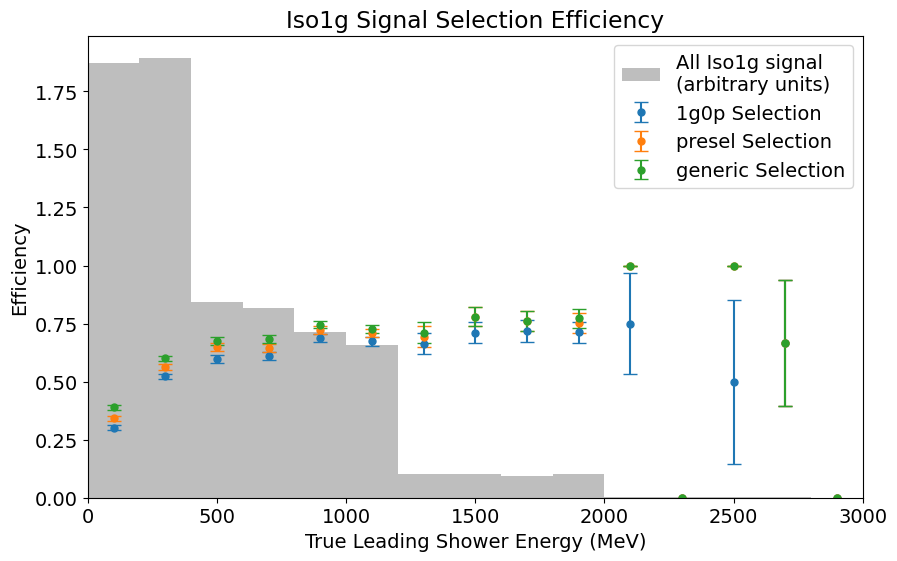

In [14]:
def frac_efficiency_stat_error(unweighted_sel, unweighted_total):
    unweighted_eff = unweighted_sel / unweighted_total
    return np.sqrt(unweighted_eff * (1 - unweighted_eff) / unweighted_total) / unweighted_eff

bins = np.linspace(0, 3000, 16)
bin_centers = (bins[:-1] + bins[1:]) / 2

sig_counts = np.histogram(all_iso1g_sig_df["wc_true_leading_shower_energy"], weights=all_iso1g_sig_df["wc_net_weight"], bins=bins)[0]
sig_counts_no_weight = np.histogram(all_iso1g_sig_df["wc_true_leading_shower_energy"], bins=bins)[0]

plt.figure(figsize=(10, 6))

plt.hist(all_iso1g_sig_df["wc_true_leading_shower_energy"], weights=1e-3*np.ones(all_iso1g_sig_df.shape[0]), bins=bins, 
    color="tab:grey", alpha=0.5, zorder=-1, label=r"All Iso1g signal" "\n(arbitrary units)")

for eff_eval_cat in ["1g0p", "presel", "generic"]:
    if eff_eval_cat == "1g0p":
        sig_sel_df = presel_iso1g_sig_1g0p_df
    elif eff_eval_cat == "presel":
        sig_sel_df = presel_iso1g_sig_df
    elif eff_eval_cat == "generic":
        sig_sel_df = generic_iso1g_sig_df

    sig_sel_counts = np.histogram(sig_sel_df["wc_true_leading_shower_energy"], weights=sig_sel_df["wc_net_weight"], bins=bins)[0]
    sig_sel_counts_no_weight = np.histogram(sig_sel_df["wc_true_leading_shower_energy"], bins=bins)[0]
    ratios = np.nan_to_num(sig_sel_counts / sig_counts)
    errs = ratios * frac_efficiency_stat_error(sig_sel_counts_no_weight, sig_counts_no_weight)
    plt.errorbar(bin_centers, ratios, yerr=errs, fmt='o', markersize=5, capsize=5, label=f"{eff_eval_cat} Selection")

plt.xlabel("True Leading Shower Energy (MeV)")
plt.ylabel("Efficiency")
plt.title("Iso1g Signal Selection Efficiency")
plt.legend()
plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.3)
plt.savefig("../plots/iso1g_shower_energy_eff.pdf")


## Del1g truth_energyInside

/tmp/ipykernel_1554402/1304018592.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(unweighted_eff * (1 - unweighted_eff) / unweighted_total) / unweighted_eff


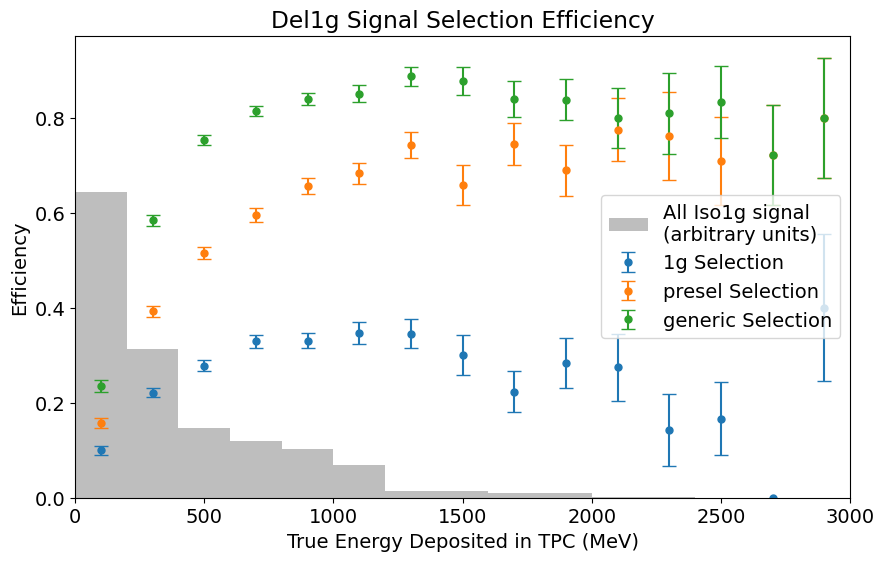

In [15]:
bins = np.linspace(0, 3000, 16)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Totals
sig_counts = np.histogram(all_del1g_sig_df["wc_truth_energyInside"], weights=all_del1g_sig_df["wc_net_weight"], bins=bins)[0]
sig_counts_no_weight = np.histogram(all_del1g_sig_df["wc_truth_energyInside"], bins=bins)[0]

plt.figure(figsize=(10, 6))

plt.hist(all_iso1g_sig_df["wc_truth_energyInside"], weights=2e-4*np.ones(all_iso1g_sig_df.shape[0]), bins=bins, 
    color="tab:grey", alpha=0.5, zorder=-1, label=r"All Iso1g signal" "\n(arbitrary units)")

for eff_eval_cat in ["1g", "presel", "generic"]:
    if eff_eval_cat == "1g":
        sig_sel_df = presel_del1g_sig_1g_combined_df
    elif eff_eval_cat == "presel":
        sig_sel_df = presel_del1g_sig_df
    elif eff_eval_cat == "generic":
        sig_sel_df = generic_del1g_sig_df

    sig_sel_counts = np.histogram(sig_sel_df["wc_truth_energyInside"], weights=sig_sel_df["wc_net_weight"], bins=bins)[0]
    sig_sel_counts_no_weight = np.histogram(sig_sel_df["wc_truth_energyInside"], bins=bins)[0]
    ratios = np.nan_to_num(sig_sel_counts / sig_counts)
    errs = ratios * frac_efficiency_stat_error(sig_sel_counts_no_weight, sig_counts_no_weight)
    plt.errorbar(bin_centers, ratios, yerr=errs, fmt='o', markersize=5, capsize=5, label=f"{eff_eval_cat} Selection")

plt.xlabel("True Energy Deposited in TPC (MeV)")
plt.ylabel("Efficiency")
plt.title("Del1g Signal Selection Efficiency")
plt.legend()
plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.3)
plt.savefig("../plots/iso1g_shower_energy_eff.pdf")


# 2D Kinematics

## Iso1g

/tmp/ipykernel_1554402/2825192746.py:41: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)
/tmp/ipykernel_1554402/2825192746.py:41: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)
/tmp/ipykernel_1554402/2825192746.py:41: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)


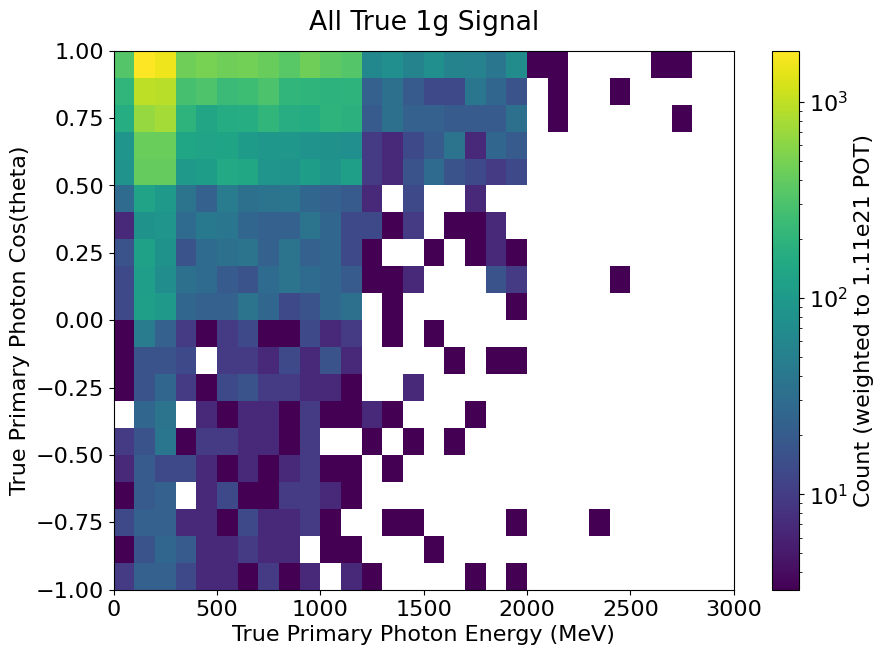

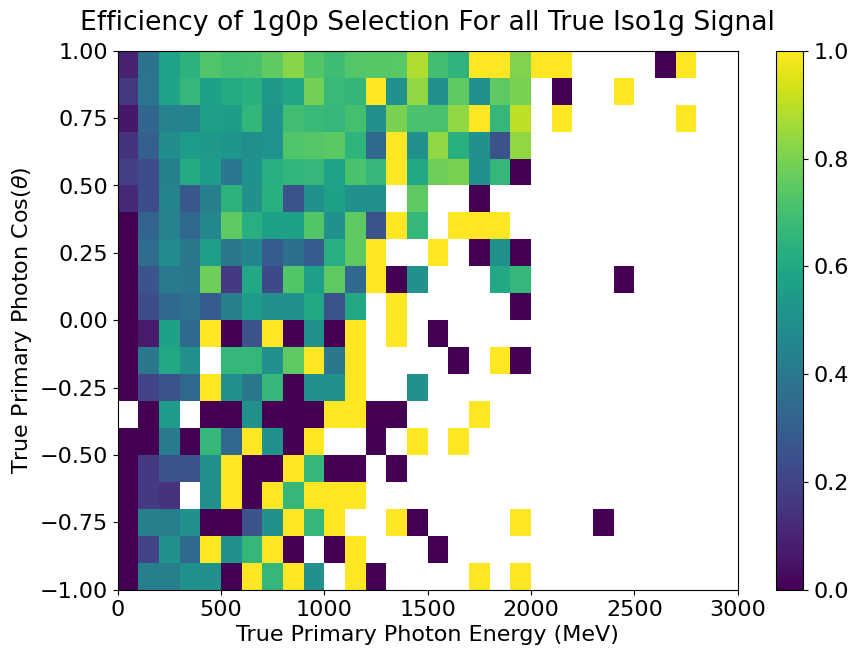

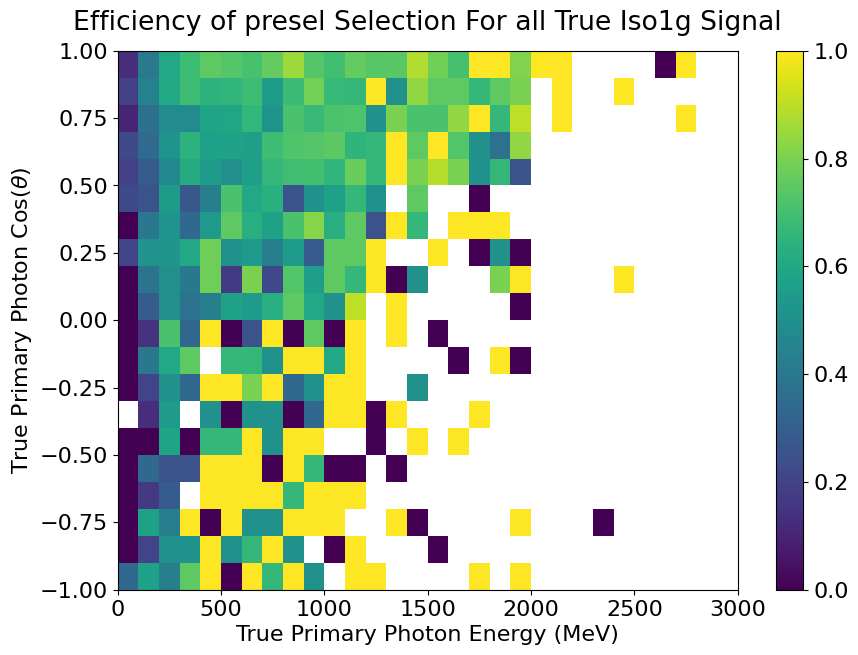

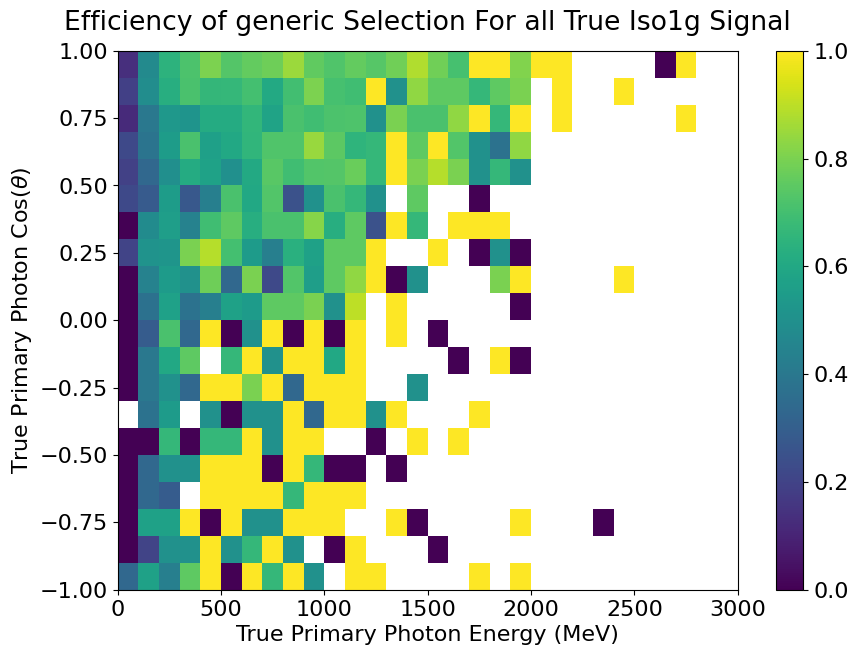

In [16]:
all_iso1g_sig_true_shower_energy = all_iso1g_sig_df["wc_true_leading_shower_energy"].to_numpy()
all_iso1g_sig_true_shower_costheta = all_iso1g_sig_df["wc_true_leading_shower_costheta"].to_numpy()
all_iso1g_sig_weights = all_iso1g_sig_df["wc_net_weight"].to_numpy()

x_bin_edges = np.linspace(0., 3000., 31)
y_bin_edges = np.linspace(-1., 1., 21)
bins = (x_bin_edges, y_bin_edges)

plt.rcParams['font.size'] = 16

plt.figure(dpi=100, figsize=(10,7))
ax = plt.gca()
plt.hist2d(all_iso1g_sig_true_shower_energy, all_iso1g_sig_true_shower_costheta, weights=all_iso1g_sig_weights, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel("True Primary Photon Energy (MeV)")
plt.ylabel("True Primary Photon Cos(theta)")
plt.colorbar(label="Count (weighted to 1.11e21 POT)")
plt.title("All True 1g Signal", pad=15)
plt.savefig("../plots/iso1g_2d_all_1g.pdf")

for eff_eval_cat in ["1g0p", "presel", "generic"]:
    if eff_eval_cat == "1g0p":
        sig_sel_df = presel_iso1g_sig_1g0p_df
    elif eff_eval_cat == "presel":
        sig_sel_df = presel_iso1g_sig_df
    elif eff_eval_cat == "generic":
        sig_sel_df = generic_iso1g_sig_df

    counts_sig, x_edges_, y_edges_ = np.histogram2d(all_iso1g_sig_df["wc_true_leading_shower_energy"].to_numpy(), all_iso1g_sig_df["wc_true_leading_shower_costheta"].to_numpy(), 
            bins=bins, weights=all_iso1g_sig_df["wc_net_weight"].to_numpy())
    counts_sig_sel, x_edges_, y_edges_ = np.histogram2d(sig_sel_df["wc_true_leading_shower_energy"].to_numpy(), sig_sel_df["wc_true_leading_shower_costheta"].to_numpy(), 
            bins=bins, weights=sig_sel_df["wc_net_weight"].to_numpy())
    wc_eff_arr = []
    bin_center_x_arr = []
    bin_center_y_arr = []
    for row in range(len(y_bin_edges) - 1):
        for col in range(len(x_bin_edges) - 1):
            bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
            bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
            numerator = counts_sig_sel[col][row]
            denominator = counts_sig[col][row]
            wc_eff_arr.append(numerator / denominator)
    plt.figure(dpi=100, figsize=(10,7))
    ax = plt.gca()
    plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=wc_eff_arr, bins=bins)
    plt.xlabel("True Primary Photon Energy (MeV)")
    plt.ylabel(r"True Primary Photon Cos($\theta$)")
    plt.colorbar()
    #plt.clim(0., 0.15)
    plt.title(f"Efficiency of {eff_eval_cat} Selection For all True Iso1g Signal", pad=15)
    plt.savefig(f"../plots/is1g_2d_eff_{eff_eval_cat}.pdf")


## Del1g

/tmp/ipykernel_1554402/4238207979.py:41: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)
/tmp/ipykernel_1554402/4238207979.py:41: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)
/tmp/ipykernel_1554402/4238207979.py:41: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)


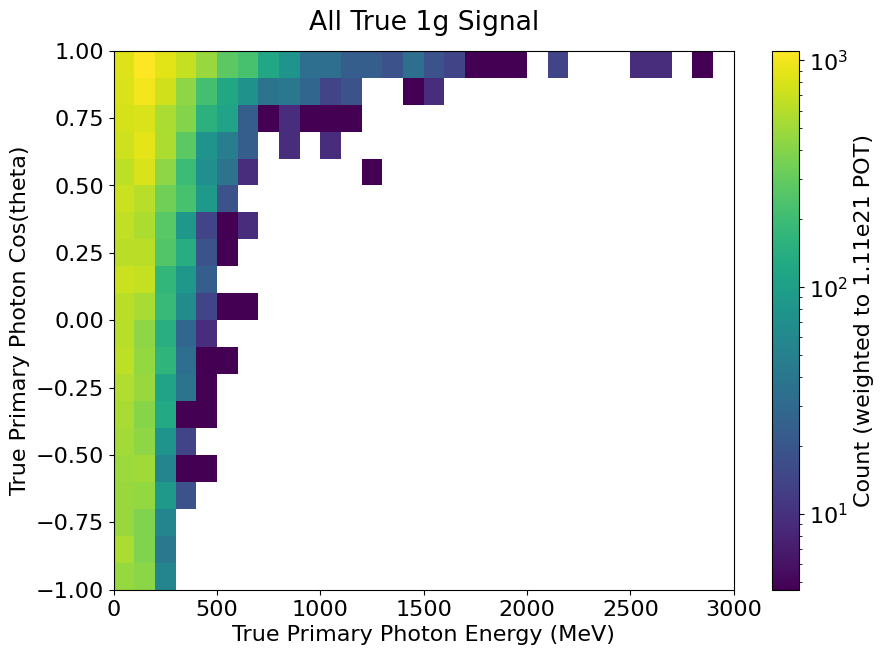

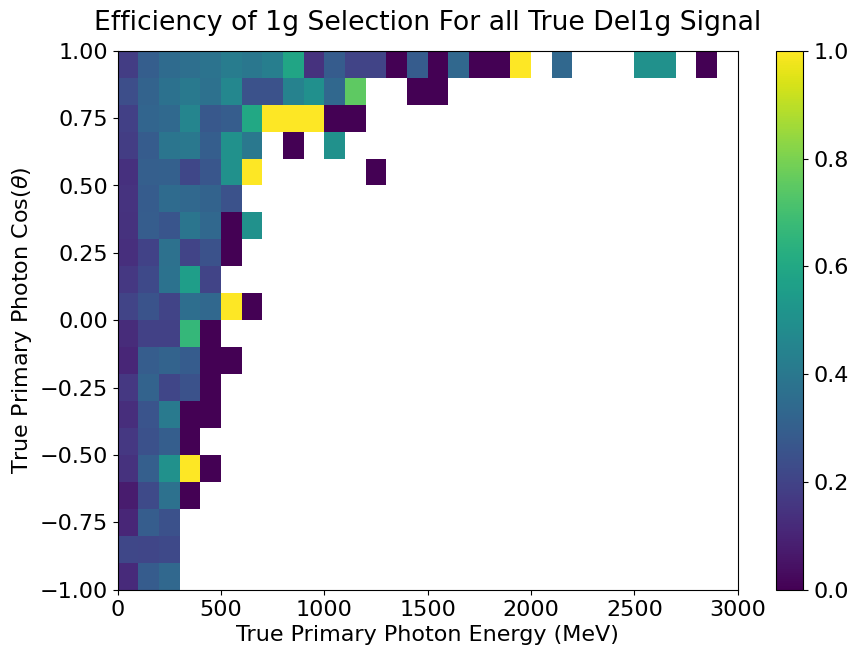

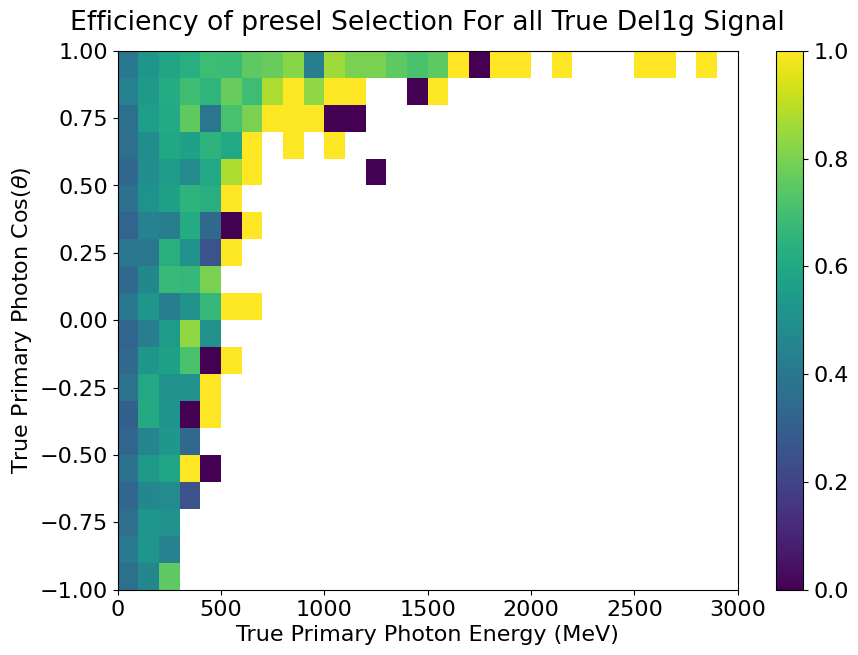

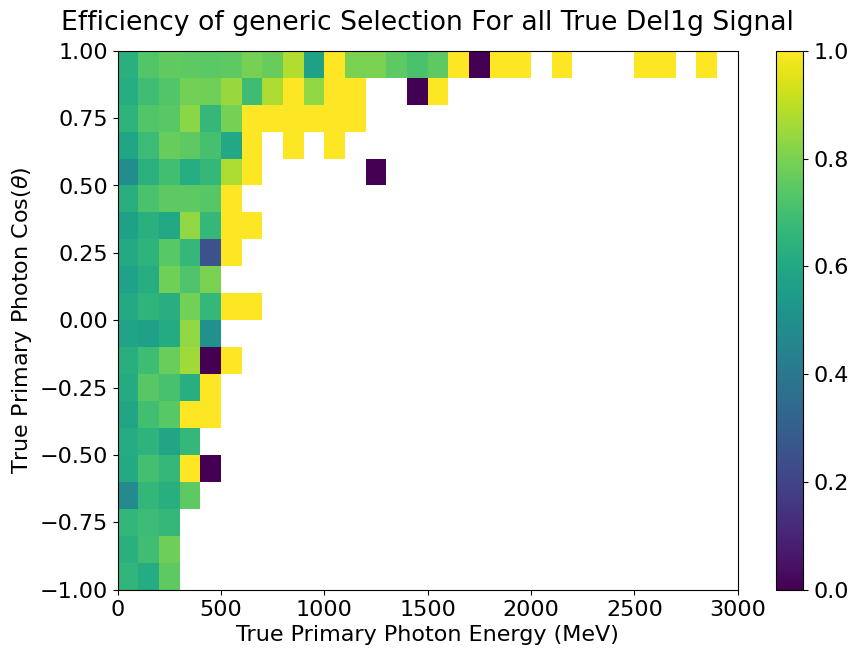

In [17]:
all_del1g_sig_true_shower_energy = all_del1g_sig_df["wc_true_leading_shower_energy"].to_numpy()
all_del1g_sig_true_shower_costheta = all_del1g_sig_df["wc_true_leading_shower_costheta"].to_numpy()
all_del1g_sig_weights = all_del1g_sig_df["wc_net_weight"].to_numpy()

x_bin_edges = np.linspace(0., 3000., 31)
y_bin_edges = np.linspace(-1., 1., 21)
bins = (x_bin_edges, y_bin_edges)

plt.rcParams['font.size'] = 16

plt.figure(dpi=100, figsize=(10,7))
ax = plt.gca()
plt.hist2d(all_del1g_sig_true_shower_energy, all_del1g_sig_true_shower_costheta, weights=all_del1g_sig_weights, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel("True Primary Photon Energy (MeV)")
plt.ylabel("True Primary Photon Cos(theta)")
plt.colorbar(label="Count (weighted to 1.11e21 POT)")
plt.title("All True 1g Signal", pad=15)
plt.savefig("../plots/del1g_2d_all_1g.pdf")

for eff_eval_cat in ["1g", "presel", "generic"]:
    if eff_eval_cat == "1g":
        sig_sel_df = presel_del1g_sig_1g_combined_df
    elif eff_eval_cat == "presel":
        sig_sel_df = presel_del1g_sig_df
    elif eff_eval_cat == "generic":
        sig_sel_df = generic_del1g_sig_df

    counts_sig, x_edges_, y_edges_ = np.histogram2d(all_del1g_sig_df["wc_true_leading_shower_energy"].to_numpy(), all_del1g_sig_df["wc_true_leading_shower_costheta"].to_numpy(), 
            bins=bins, weights=all_del1g_sig_df["wc_net_weight"].to_numpy())
    counts_sig_sel, x_edges_, y_edges_ = np.histogram2d(sig_sel_df["wc_true_leading_shower_energy"].to_numpy(), sig_sel_df["wc_true_leading_shower_costheta"].to_numpy(), 
            bins=bins, weights=sig_sel_df["wc_net_weight"].to_numpy())
    wc_eff_arr = []
    bin_center_x_arr = []
    bin_center_y_arr = []
    for row in range(len(y_bin_edges) - 1):
        for col in range(len(x_bin_edges) - 1):
            bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
            bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
            numerator = counts_sig_sel[col][row]
            denominator = counts_sig[col][row]
            wc_eff_arr.append(numerator / denominator)
    plt.figure(dpi=100, figsize=(10,7))
    ax = plt.gca()
    plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=wc_eff_arr, bins=bins)
    plt.xlabel("True Primary Photon Energy (MeV)")
    plt.ylabel(r"True Primary Photon Cos($\theta$)")
    plt.colorbar()
    #plt.clim(0., 0.15)
    plt.title(f"Efficiency of {eff_eval_cat} Selection For all True Del1g Signal", pad=15)
    plt.savefig(f"../plots/del1g_2d_eff_{eff_eval_cat}.pdf")
